[Przetwarzanie ETL w Google Cloud przy użyciu Dataflow i BigQuery](https://www.cloudskillsboost.google/focuses/3460?catalog_rank=%7B%22rank%22%3A17%2C%22num_filters%22%3A0%2C%22has_search%22%3Atrue%7D&parent=catalog&search_id=23522184)

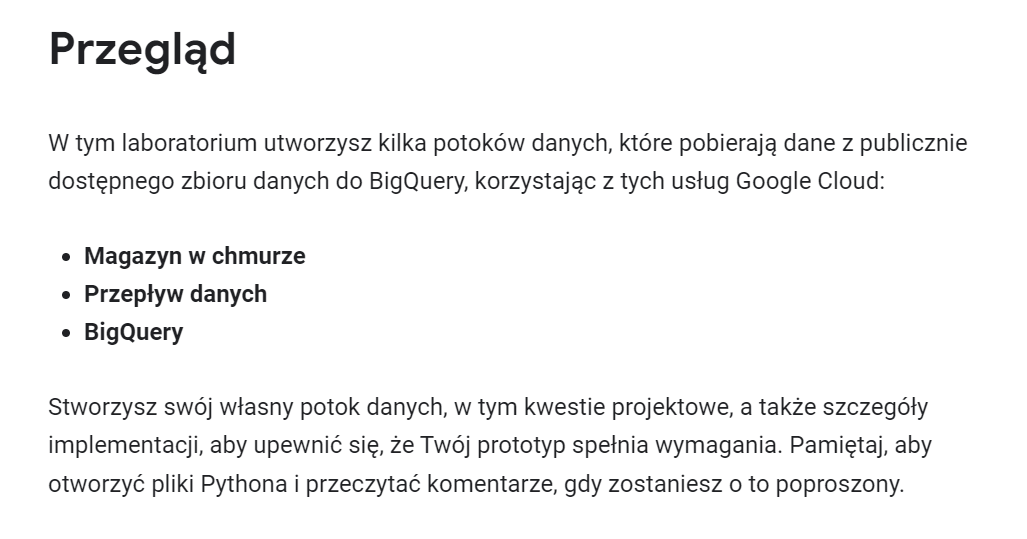

#Zadanie 1. Upewnij się, że interfejs Dataflow API został pomyślnie włączony

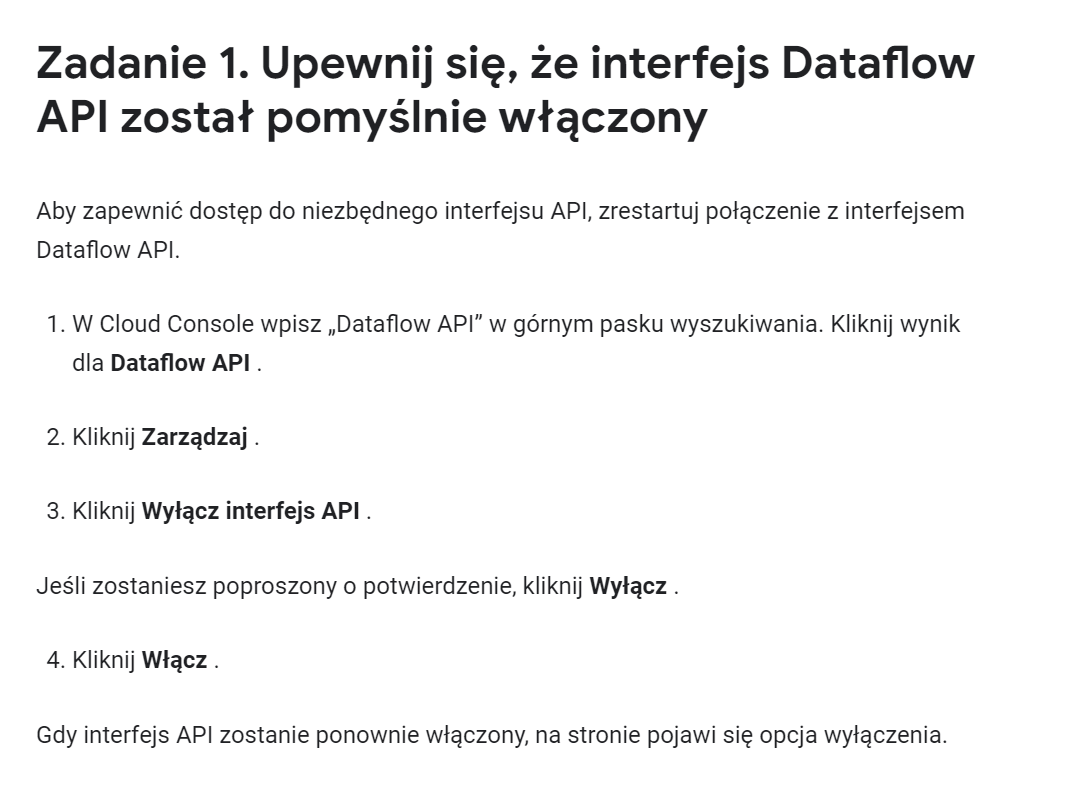

In [ ]:
# https://github.com/GoogleCloudPlatform/professional-services/blob/main/examples/dataflow-python-examples/README.md

#Zadanie 2. Pobierz kod startowy

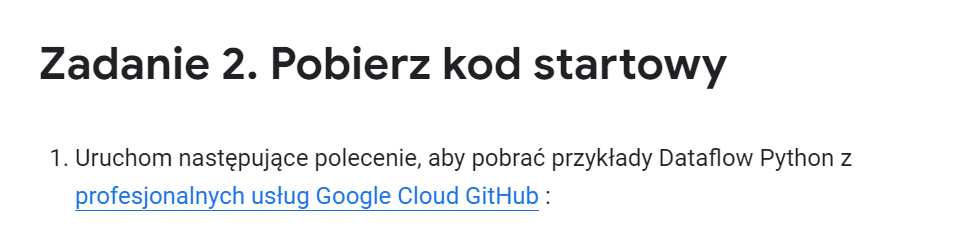

Pobieranie z GCS zasobów do Cloud Shell Editor

In [ ]:
gsutil -m cp -R gs://spls/gsp290/dataflow-python-examples .

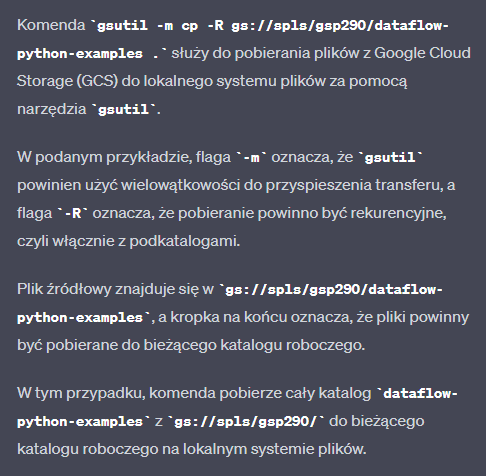

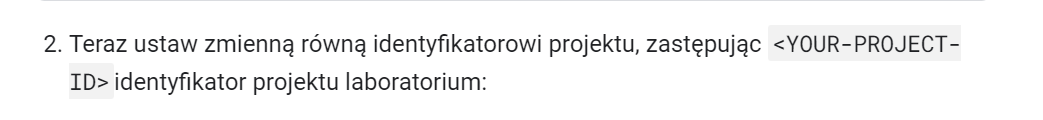

In [ ]:
export PROJECT=qwiklabs-gcp-03-9b9b4e35526b

In [ ]:
gcloud config set project $PROJECT

#Zadanie 3. Utwórz zasobnik Cloud Storage

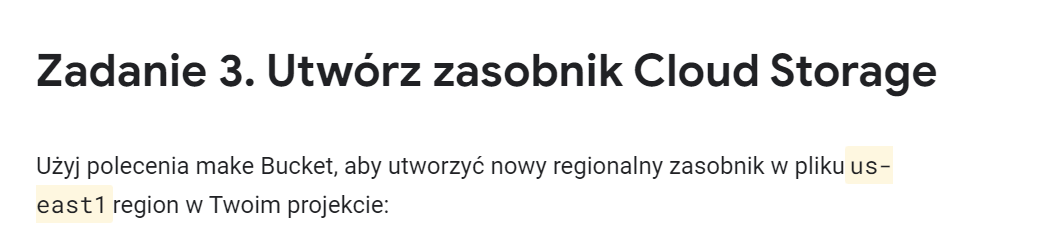

In [ ]:
gsutil mb -c regional -l us-east1  gs://$PROJECT

#Zadanie 4. Skopiuj pliki do swojego zasobnika

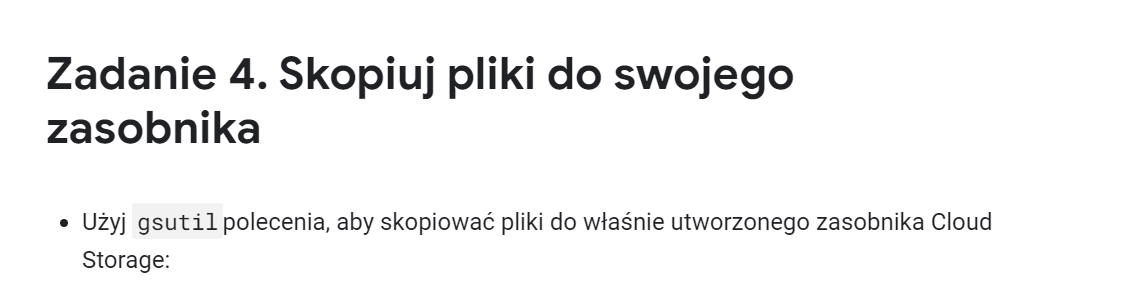

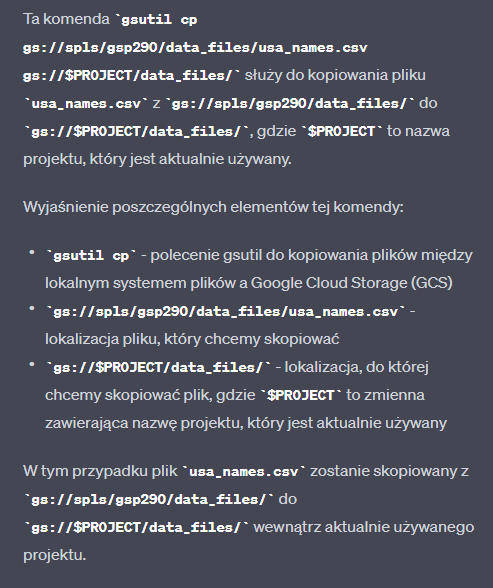

In [ ]:
gsutil cp gs://spls/gsp290/data_files/usa_names.csv gs://$PROJECT/data_files/
gsutil cp gs://spls/gsp290/data_files/head_usa_names.csv gs://$PROJECT/data_files/

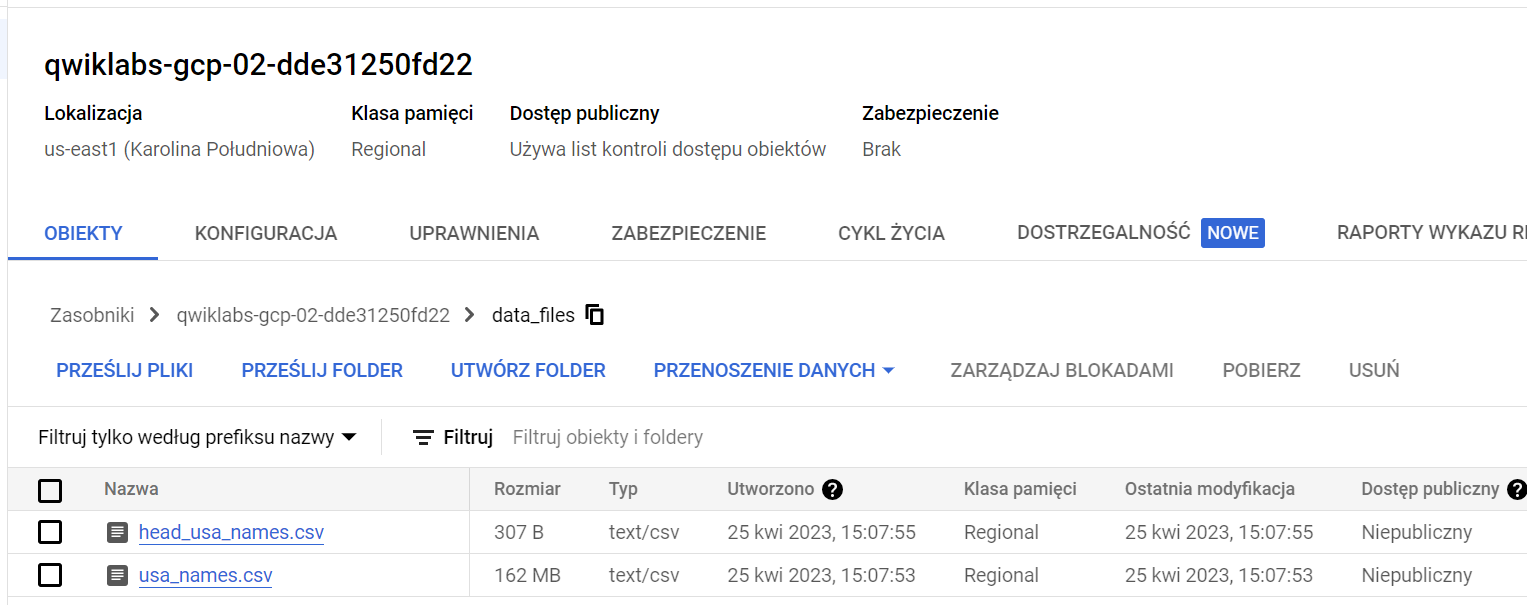

In [ ]:
# qa-empik-mobile-app/data_files/head_usa_names.csv

state,gender,year,name,number,created_date
AK,F,1910,Dorothy,5,11/28/2016
AK,F,1910,Lucy,6,11/28/2016
AK,M,1910,George,5,11/28/2016
AK,M,1910,Paul,6,11/28/2016
AK,M,1910,William,5,11/28/2016
AK,F,1910,Anna,10,11/28/2016
AK,F,1910,Mary,14,11/28/2016
AK,F,1910,Helen,7,11/28/2016
AK,M,1910,James,7,11/28/2016

In [ ]:
# qa-empik-mobile-app/data_files/usa_names.csv

state,gender,year,name,number,created_date
AK,F,1910,Dorothy,5,11/28/2016
AK,F,1910,Lucy,6,11/28/2016
AK,M,1910,George,5,11/28/2016
AK,M,1910,Paul,6,11/28/2016
AK,M,1910,William,5,11/28/2016
AK,F,1910,Anna,10,11/28/2016
AK,F,1910,Mary,14,11/28/2016
AK,F,1910,Helen,7,11/28/2016
AK,M,1910,James,7,11/28/2016
AK,M,1910,Carl,5,11/28/2016
AK,M,1910,Edward,5,11/28/2016
AK,F,1910,Elsie,6,11/28/2016
AK,F,1910,Margaret,8,11/28/2016
AK,M,1910,John,8,11/28/2016
AK,M,1910,Robert,6,11/28/2016
AK,F,1910,Annie,12,11/28/2016
AL,M,1910,Solomon,6,11/28/2016
AL,M,1910,Eli,5,11/28/2016
AL,F,1910,Viola,78,11/28/2016
AL,F,1910,Katherine,36,11/28/2016
AL,F,1910,Barbara,6,11/28/2016
AL,F,1910,Melba,6,11/28/2016
AL,F,1910,Lovie,5,11/28/2016
AL,F,1910,Sarah,107,11/28/2016
AL,F,1910,Josie,35,11/28/2016
AL,F,1910,Jannie,14,11/28/2016
AL,F,1910,Willa,10,11/28/2016
AL,M,1910,William,343,11/28/2016
AL,M,1910,Walter,92,11/28/2016
AL,M,1910,Elbert,14,11/28/2016
AL,M,1910,Sandy,9,11/28/2016

#Zadanie 5. Utwórz zbiór danych BigQuery

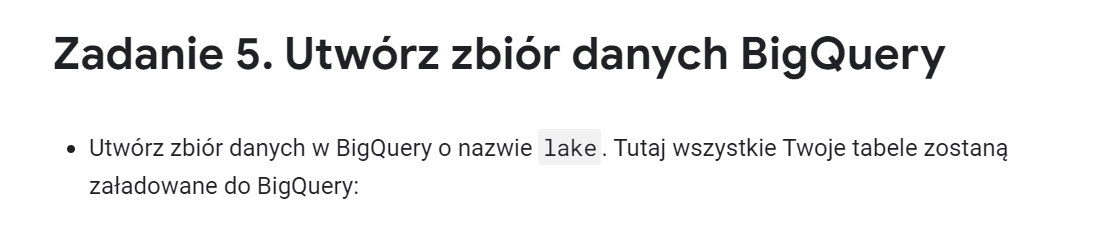

In [ ]:
bq mk lake

#Zadanie 6. Zbuduj potok przepływu danych

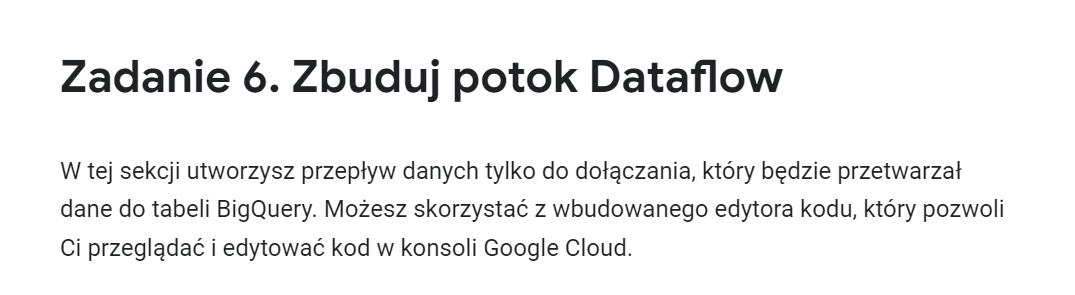

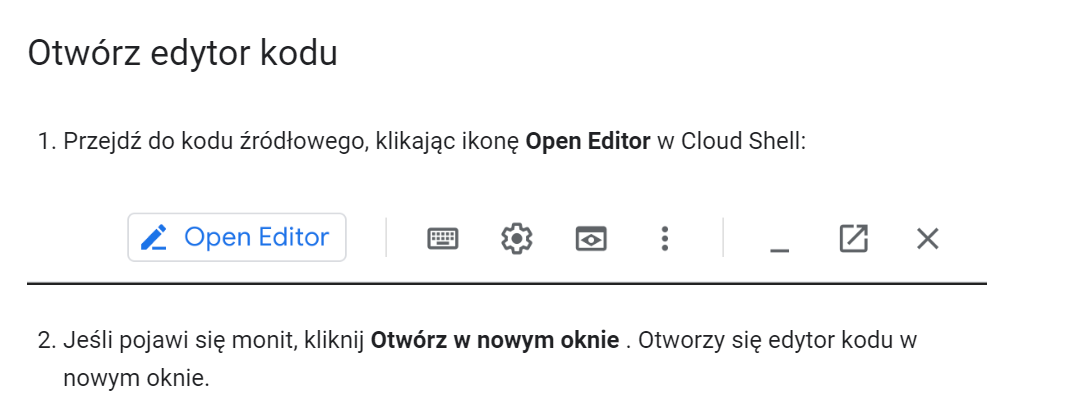

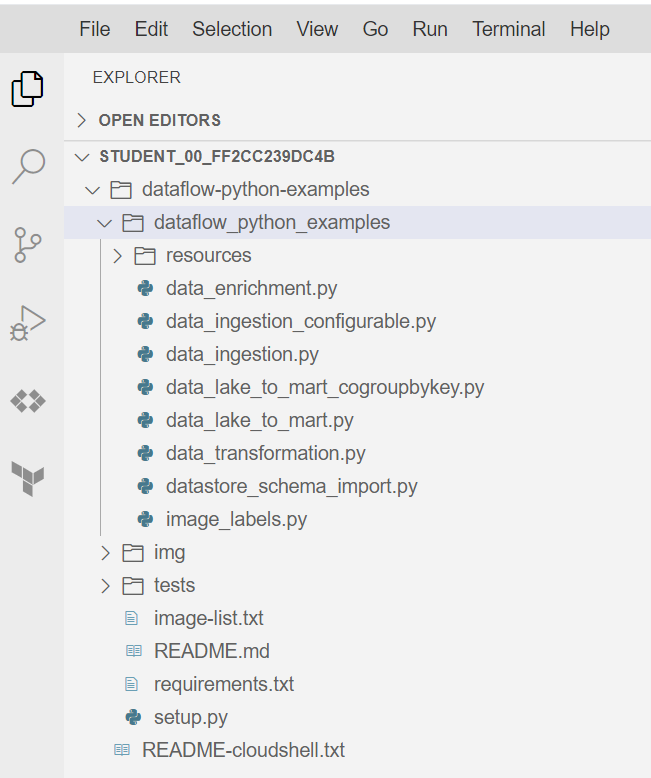

#Zadanie 7. Pozyskiwanie danych za pomocą Dataflow Pipeline

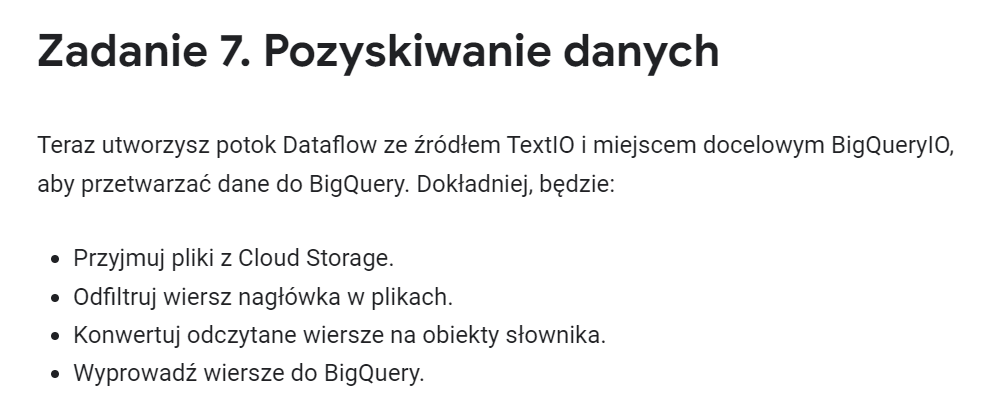

#Zadanie 8. Przejrzyj kod potokowy w języku Python

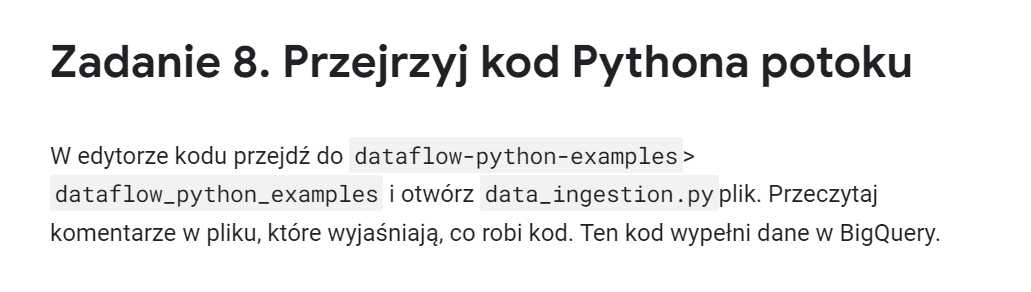

##`data_ingestion.py`

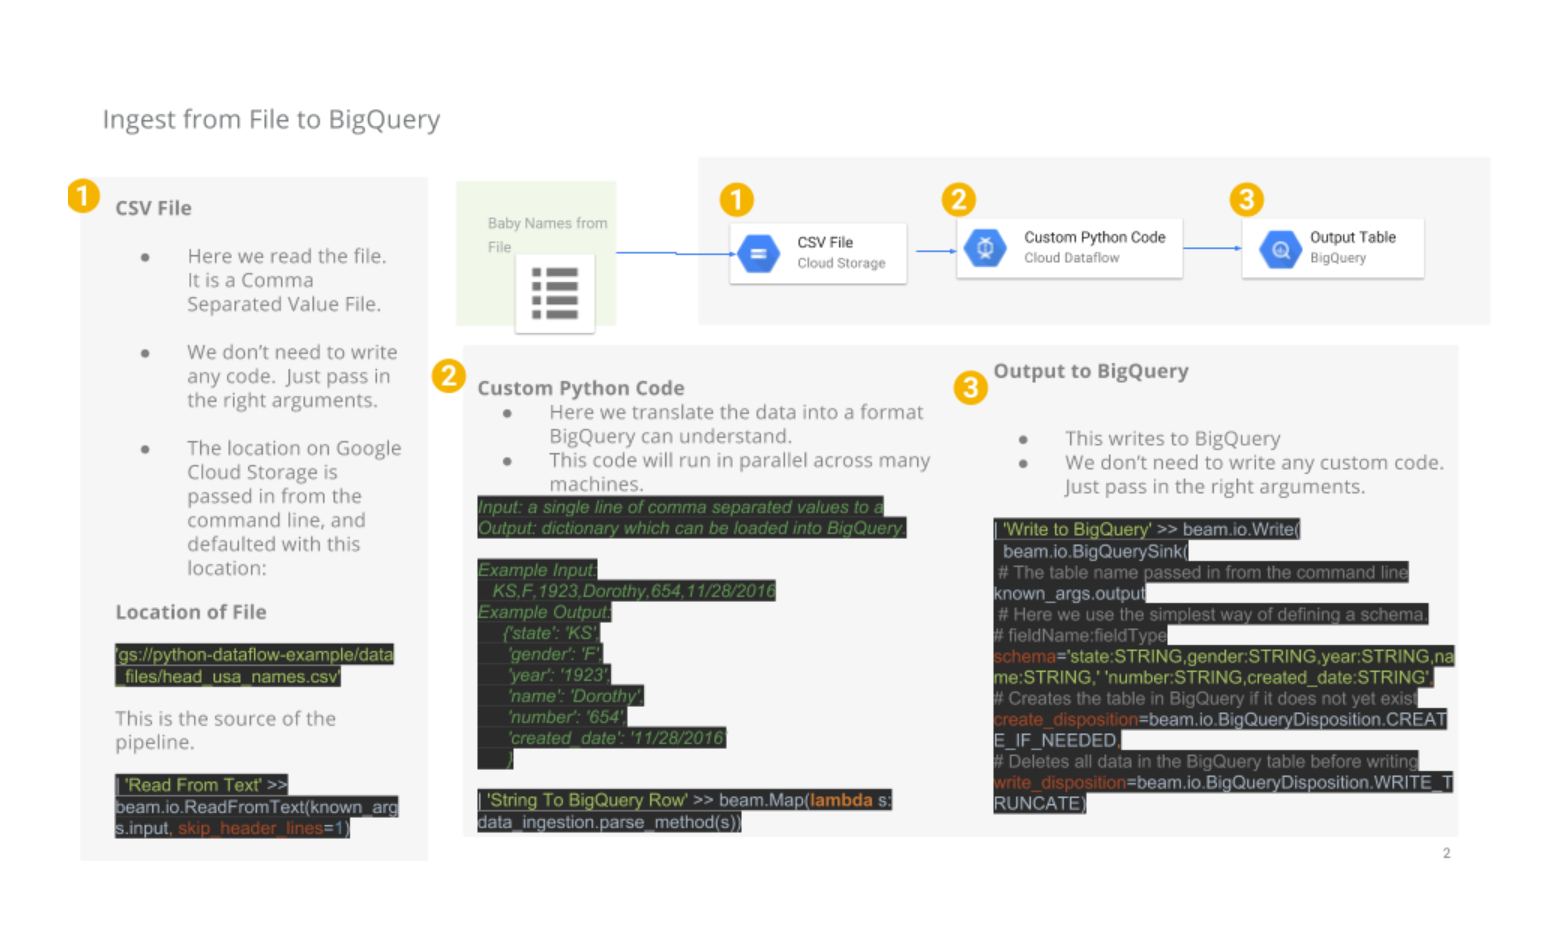

In [ ]:
# Copyright 2017 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""`data_ingestion.py` is a Dataflow pipeline which reads a file and writes its
contents to a BigQuery table.
This example does not do any transformation on the data.
"""


import argparse
import logging
import re
import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions


class DataIngestion:
    """A helper class which contains the logic to translate the file into
    a format BigQuery will accept."""
    def parse_method(self, string_input):
        """This method translates a single line of comma separated values to a
        dictionary which can be loaded into BigQuery.

        Args:
            string_input: A comma separated list of values in the form of
                state_abbreviation,gender,year,name,count_of_babies,dataset_created_date
                Example string_input: KS,F,1923,Dorothy,654,11/28/2016

        Returns:
            A dict mapping BigQuery column names as keys to the corresponding value
            parsed from string_input. In this example, the data is not transformed, and
            remains in the same format as the CSV.
            example output:
            {
                'state': 'KS',
                'gender': 'F',
                'year': '1923',
                'name': 'Dorothy',
                'number': '654',
                'created_date': '11/28/2016'
            }
         """
        # Strip out carriage return, newline and quote characters.
        values = re.split(",",
                          re.sub('\r\n', '', re.sub('"', '', string_input)))
        row = dict(
            zip(('state', 'gender', 'year', 'name', 'number', 'created_date'),
                values))
        return row


def run(argv=None):
    """The main function which creates the pipeline and runs it."""

    parser = argparse.ArgumentParser()

    # Here we add some specific command line arguments we expect.
    # Specifically we have the input file to read and the output table to write.
    # This is the final stage of the pipeline, where we define the destination
    # of the data. In this case we are writing to BigQuery.
    parser.add_argument(
        '--input',
        dest='input',
        required=False,
        help='Input file to read. This can be a local file or '
        'a file in a Google Storage Bucket.',
        # This example file contains a total of only 10 lines.
        # Useful for developing on a small set of data.
        default='gs://spls/gsp290/data_files/head_usa_names.csv')

    # This defaults to the lake dataset in your BigQuery project. You'll have
    # to create the lake dataset yourself using this command:
    # bq mk lake
    parser.add_argument('--output',
                        dest='output',
                        required=False,
                        help='Output BQ table to write results to.',
                        default='lake.usa_names')

    # Parse arguments from the command line.
    known_args, pipeline_args = parser.parse_known_args(argv)

    # DataIngestion is a class we built in this script to hold the logic for
    # transforming the file into a BigQuery table.
    data_ingestion = DataIngestion()

    # Initiate the pipeline using the pipeline arguments passed in from the
    # command line. This includes information such as the project ID and
    # where Dataflow should store temp files.
    p = beam.Pipeline(options=PipelineOptions(pipeline_args))

    (p
     # Read the file. This is the source of the pipeline. All further
     # processing starts with lines read from the file. We use the input
     # argument from the command line. We also skip the first line which is a
     # header row.
     | 'Read from a File' >> beam.io.ReadFromText(known_args.input,
                                                  skip_header_lines=1)
     # This stage of the pipeline translates from a CSV file single row
     # input as a string, to a dictionary object consumable by BigQuery.
     # It refers to a function we have written. This function will
     # be run in parallel on different workers using input from the
     # previous stage of the pipeline.
     | 'String To BigQuery Row' >>
     beam.Map(lambda s: data_ingestion.parse_method(s))
     | 'Write to BigQuery' >> beam.io.Write(
         beam.io.BigQuerySink(
             # The table name is a required argument for the BigQuery sink.
             # In this case we use the value passed in from the command line.
             known_args.output,
             # Here we use the simplest way of defining a schema:
             # fieldName:fieldType
             schema='state:STRING,gender:STRING,year:STRING,name:STRING,'
             'number:STRING,created_date:STRING',
             # Creates the table in BigQuery if it does not yet exist.
             create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
             # Deletes all data in the BigQuery table before writing.
             write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE)))
    p.run().wait_until_finish()


if __name__ == '__main__':
    logging.getLogger().setLevel(logging.INFO)
    run()

In [ ]:
import re

string_input = 'value1,"value2",value3\r\n'
print("String przed przetwarzaniem:", string_input)

# Usunięcie cudzysłowów i znaków nowej linii
processed_string = re.sub('\r\n', '', re.sub('"', '', string_input))
print("String po przetwarzaniu:", processed_string)

# Podział na wartości po przecinkach
values = re.split(",", processed_string)
print("Podzielone wartości:", values)

String przed przetwarzaniem: value1,"value2",value3

String po przetwarzaniu: value1,value2,value3
Podzielone wartości: ['value1', 'value2', 'value3']


In [ ]:
# Importujemy niezbędne biblioteki i klasy:
import argparse  # Biblioteka do obsługi argumentów wiersza poleceń.
import logging   # Biblioteka do logowania zdarzeń.
import re        # Biblioteka do obsługi wyrażeń regularnych.
import apache_beam as beam  # Główna biblioteka do tworzenia potoków danych w Apache Beam.
from apache_beam.options.pipeline_options import PipelineOptions  # Importuje opcje potoku danych.

class DataIngestion:
    """Klasa pomocnicza zawierająca logikę przekształcania pliku wejściowego
    na format akceptowany przez BigQuery."""
    def parse_method(self, string_input):
        """Ta metoda tłumaczy pojedynczy wiersz wartości oddzielonych przecinkami
        na słownik, który można załadować do BigQuery."""
        # Usuwamy znaki powrotu karetki, nowej linii i cudzysłowia.
        values = re.split(",",
                          re.sub('\r\n', '', re.sub('"', '', string_input)))
        # Tworzymy słownik mapujący nazwy kolumn w BigQuery na odpowiadające im wartości.
        row = dict(
            zip(('state', 'gender', 'year', 'name', 'number', 'created_date'),
                values))
        return row

def run(argv=None):
    """Główna funkcja, która tworzy potok danych i uruchamia go."""
    # Inicjalizacja parsera argumentów wiersza poleceń.
    parser = argparse.ArgumentParser()

    # Dodanie argumentów wiersza poleceń: '--input' i '--output'.
    # '--input': ścieżka do pliku wejściowego. Domyślnie ustawiona na plik 'head_usa_names.csv' w Google Storage Bucket.
    # '--output': tabela BigQuery, do której zostaną zapisane wyniki. Domyślnie ustawiona na 'lake.usa_names'.
    parser.add_argument(
        '--input',
        dest='input',
        required=False,
        help='Input file to read. This can be a local file or '
        'a file in a Google Storage Bucket.',
        default='gs://spls/gsp290/data_files/head_usa_names.csv')
    parser.add_argument('--output',
                        dest='output',
                        required=False,
                        help='Output BQ table to write results to.',
                        default='lake.usa_names')

    # Parsowanie argumentów z wiersza poleceń.
    # known_args: obiekt zawierający przetworzone argumenty, które parser rozpoznał.
    # pipeline_args: lista argumentów nie rozpoznanych przez parser.
    """parser.parse_known_args(argv): Ta metoda parsuje argumenty wiersza poleceń przekazane do programu i
    zwraca dwa obiekty: known_args i pipeline_args."""
    known_args, pipeline_args = parser.parse_known_args(argv)

    # Tworzymy instancję klasy DataIngestion.
    data_ingestion = DataIngestion()

    # Inicjujemy potok danych, używając opcji potoku danych przekazanych z wiersza poleceń.
    p = beam.Pipeline(options=PipelineOptions(pipeline_args))

    (p
     # Odczytujemy plik. Jest to źródło potoku danych.
     | 'Read from a File' >> beam.io.ReadFromText(known_args.input,
                                                  skip_header_lines=1)
     # W tym etapie potoku przekształcamy pojedynczy wiersz pliku CSV jako string
     # na obiekt słownika, który można przekazać do BigQuery.
     | 'String To BigQuery Row' >>
     beam.Map(lambda s: data_ingestion.parse_method(s))
     | 'Write to BigQuery' >> beam.io.Write(
         beam.io.BigQuerySink(
             known_args.output,  # Nazwa tabeli BigQuery.
             schema='state:STRING,gender:STRING,year:STRING,name:STRING,'
                    'number:STRING,created_date:STRING',  # Schemat tabeli BigQuery.
             create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
             write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE)))  # Operacja zapisu do BigQuery.

    # Uruchamiamy potok danych.
    p.run().wait_until_finish()

# Jeśli plik jest uruchamiany jako skrypt, wywołujemy funkcję `run`.
if __name__ == '__main__':
    logging.getLogger().setLevel(logging.INFO)
    run()


#Zadanie 9. Uruchom potok Apache Beam

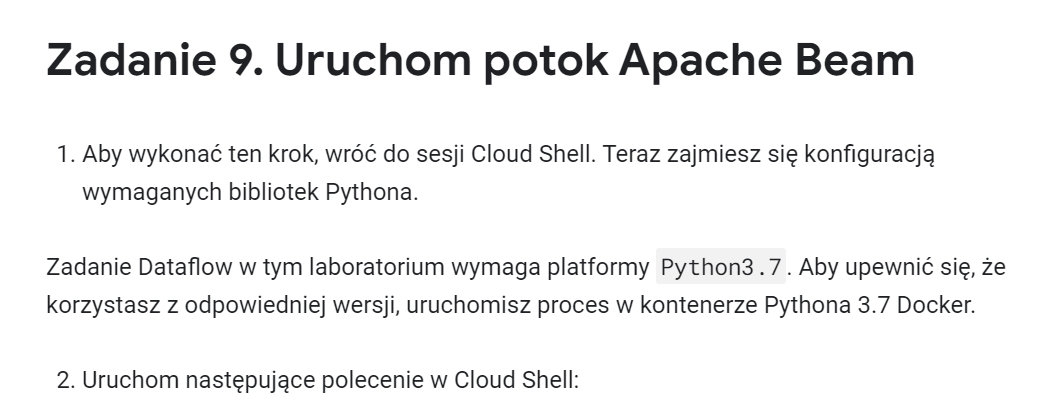

In [ ]:
docker run -it -e PROJECT=$PROJECT -v $(pwd)/dataflow-python-examples:/dataflow python:3.8 /bin/bash

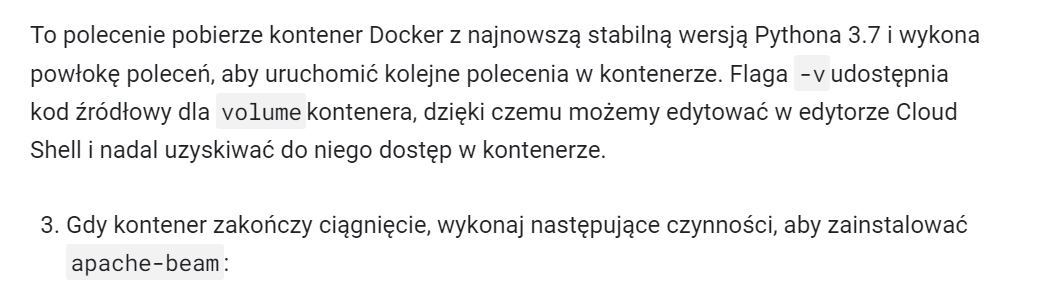

In [ ]:
pip install apache-beam[gcp]==2.24.0

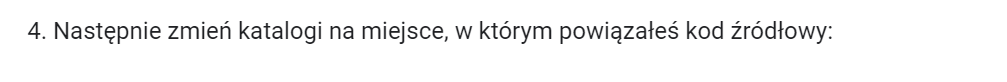

In [ ]:
cd dataflow/

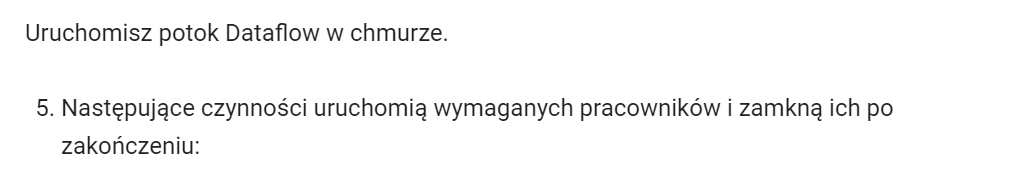

In [ ]:
python dataflow_python_examples/data_ingestion.py \
  --project=$PROJECT --region= \
  --runner=DataflowRunner \
  --machine_type=e2-standard-2 \
  --staging_location=gs://$PROJECT/test \
  --temp_location gs://$PROJECT/test \
  --input gs://$PROJECT/data_files/head_usa_names.csv \
  --save_main_session

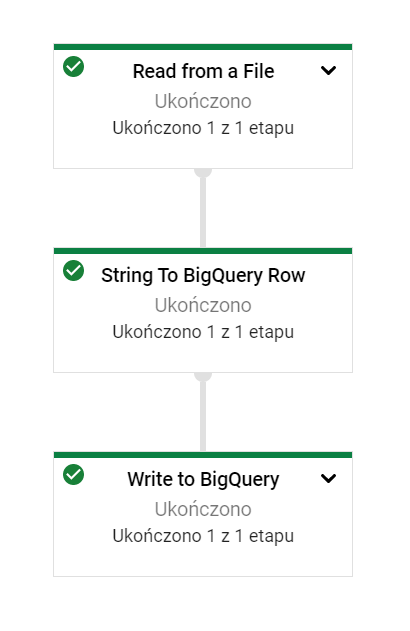

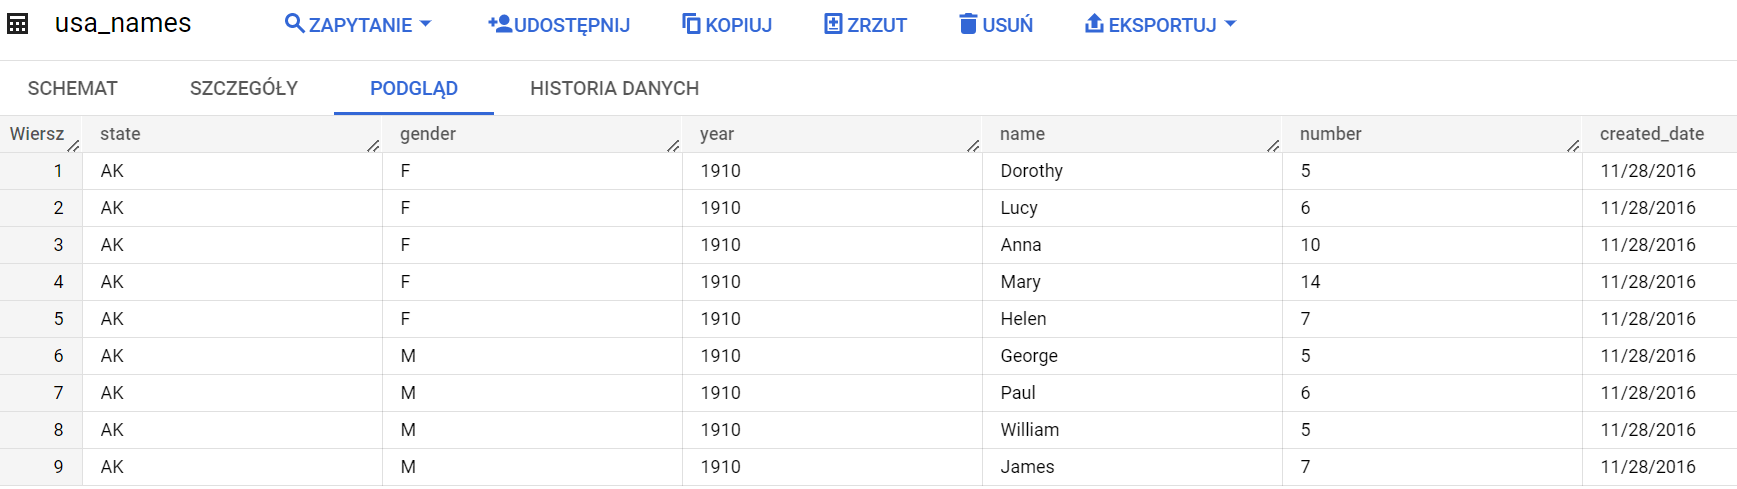

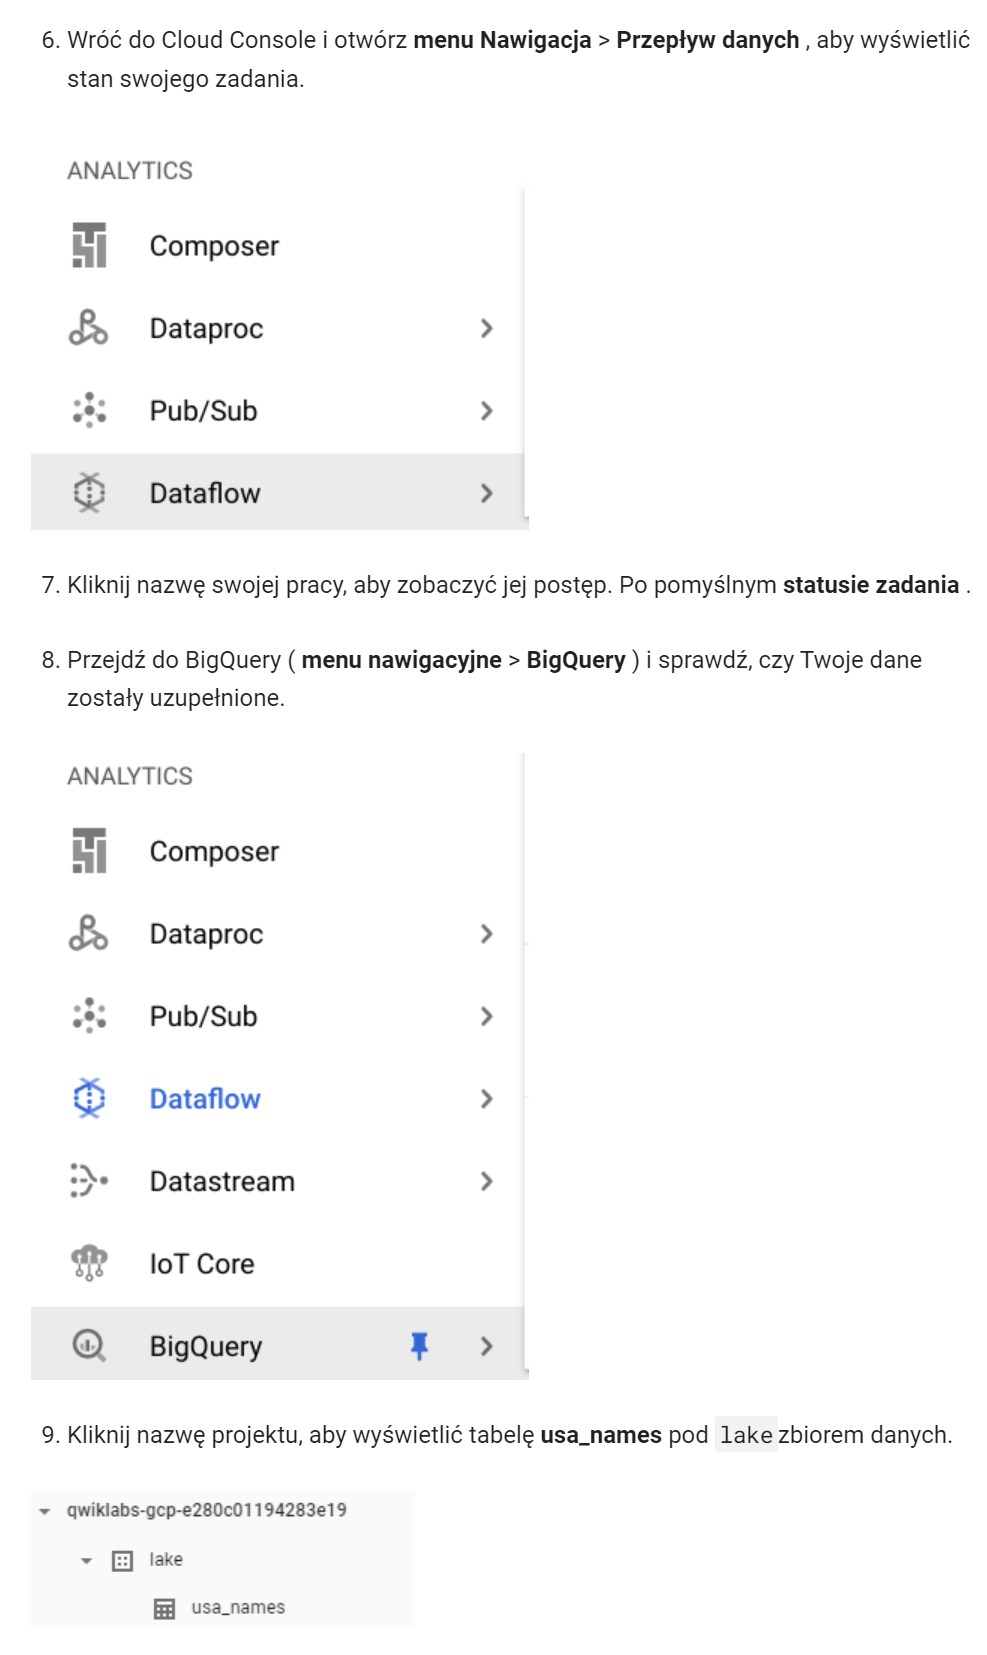

#Zadanie 10. Transformacja danych

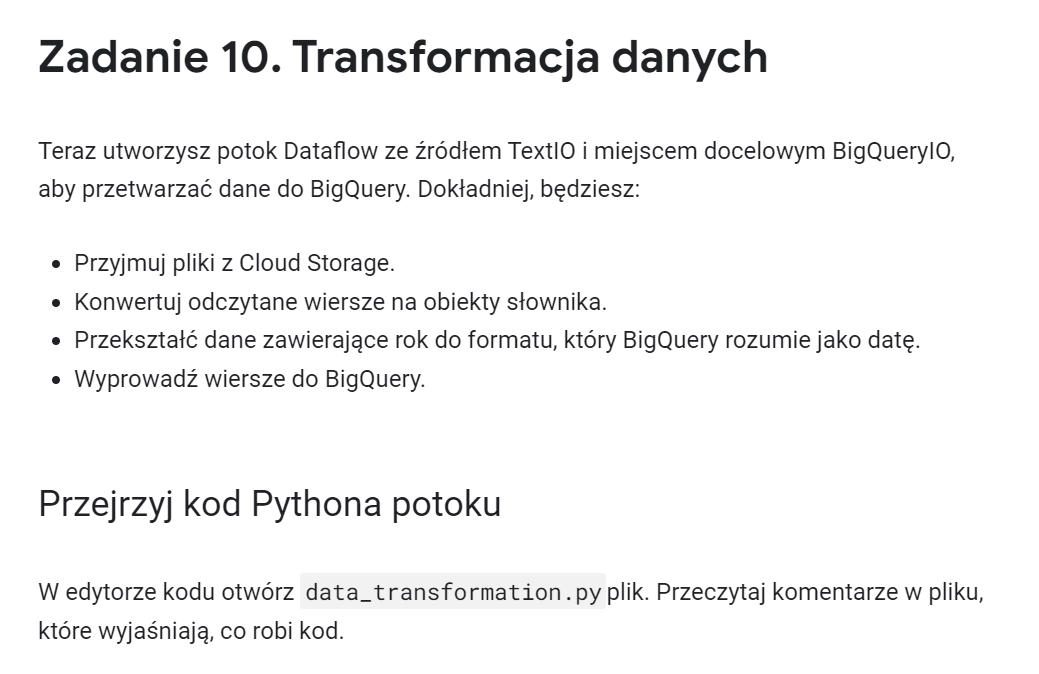

##`data_transformation.py`

In [ ]:
# Copyright 2017 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

""" data_transformation.py is a Dataflow pipeline which reads a file and writes
its contents to a BigQuery table.

This example reads a json schema of the intended output into BigQuery,
and transforms the date data to match the format BigQuery expects.
"""


import argparse
import csv
import logging
import os

import apache_beam as beam
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.io.gcp.bigquery_tools import parse_table_schema_from_json


class DataTransformation:
    """A helper class which contains the logic to translate the file into a
  format BigQuery will accept."""

    def __init__(self):
        dir_path = os.path.dirname(os.path.realpath(__file__))
        self.schema_str = ''
        # Here we read the output schema from a json file.  This is used to specify the types
        # of data we are writing to BigQuery.
        schema_file = os.path.join(dir_path, 'resources', 'usa_names_year_as_date.json')
        with open(schema_file) \
                as f:
            data = f.read()
            # Wrapping the schema in fields is required for the BigQuery API.
            self.schema_str = '{"fields": ' + data + '}'

    def parse_method(self, string_input):
        """This method translates a single line of comma separated values to a
    dictionary which can be loaded into BigQuery.

        Args:
            string_input: A comma separated list of values in the form of
            state_abbreviation,gender,year,name,count_of_babies,dataset_created_date
                example string_input: KS,F,1923,Dorothy,654,11/28/2016

        Returns:
            A dict mapping BigQuery column names as keys to the corresponding value
            parsed from string_input.  In this example, the data is not transformed, and
            remains in the same format as the CSV.  There are no date format transformations.

                example output:
                      {'state': 'KS',
                       'gender': 'F',
                       'year': '1923-01-01', <- This is the BigQuery date format.
                       'name': 'Dorothy',
                       'number': '654',
                       'created_date': '11/28/2016'
                       }
        """
        # Strip out return characters and quote characters.
        schema = parse_table_schema_from_json(self.schema_str)

        field_map = [f for f in schema.fields]

        # Use a CSV Reader which can handle quoted strings etc.
        reader = csv.reader(string_input.split('\n'))
        for csv_row in reader:
            # Our source data only contains year, so default January 1st as the
            # month and day.
            month = '01'
            day = '01'
            # The year comes from our source data.
            year = csv_row[2]

            row = {}
            i = 0
            # Iterate over the values from our csv file, applying any transformation logic.
            for value in csv_row:
                # If the schema indicates this field is a date format, we must
                # transform the date from the source data into a format that
                # BigQuery can understand.
                if field_map[i].type == 'DATE':
                    # Format the date to YYYY-MM-DD format which BigQuery
                    # accepts.
                    value = '-'.join((year, month, day))

                row[field_map[i].name] = value
                i += 1

            return row


def run(argv=None):
    """The main function which creates the pipeline and runs it."""
    parser = argparse.ArgumentParser()
    # Here we add some specific command line arguments we expect.   Specifically
    # we have the input file to load and the output table to write to.
    parser.add_argument(
        '--input', dest='input', required=False,
        help='Input file to read.  This can be a local file or '
             'a file in a Google Storage Bucket.',
        # This example file contains a total of only 10 lines.
        # It is useful for developing on a small set of data
        default='gs://spls/gsp290/data_files/head_usa_names.csv')
    # This defaults to the temp dataset in your BigQuery project.  You'll have
    # to create the temp dataset yourself using bq mk temp
    parser.add_argument('--output', dest='output', required=False,
                        help='Output BQ table to write results to.',
                        default='lake.usa_names_transformed')

    # Parse arguments from the command line.
    known_args, pipeline_args = parser.parse_known_args(argv)
    # DataTransformation is a class we built in this script to hold the logic for
    # transforming the file into a BigQuery table.
    data_ingestion = DataTransformation()

    # Initiate the pipeline using the pipeline arguments passed in from the
    # command line.  This includes information like where Dataflow should
    # store temp files, and what the project id is.
    p = beam.Pipeline(options=PipelineOptions(pipeline_args))
    schema = parse_table_schema_from_json(data_ingestion.schema_str)

    (p
     # Read the file.  This is the source of the pipeline.  All further
     # processing starts with lines read from the file.  We use the input
     # argument from the command line.  We also skip the first line which is a
     # header row.
     | 'Read From Text' >> beam.io.ReadFromText(known_args.input,
                                                skip_header_lines=1)
     # This stage of the pipeline translates from a CSV file single row
     # input as a string, to a dictionary object consumable by BigQuery.
     # It refers to a function we have written.  This function will
     # be run in parallel on different workers using input from the
     # previous stage of the pipeline.
     | 'String to BigQuery Row' >> beam.Map(lambda s:
                                            data_ingestion.parse_method(s))
     | 'Write to BigQuery' >> beam.io.Write(
        beam.io.BigQuerySink(
            # The table name is a required argument for the BigQuery sink.
            # In this case we use the value passed in from the command line.
            known_args.output,
            # Here we use the JSON schema read in from a JSON file.
            # Specifying the schema allows the API to create the table correctly if it does not yet exist.
            schema=schema,
            # Creates the table in BigQuery if it does not yet exist.
            create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
            # Deletes all data in the BigQuery table before writing.
            write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE)))
    p.run().wait_until_finish()


if __name__ == '__main__':
    logging.getLogger().setLevel(logging.INFO)
    run()


In [ ]:
# Copyright 2017 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

""" data_transformation.py is a Dataflow pipeline which reads a file and writes
its contents to a BigQuery table.

This example reads a json schema of the intended output into BigQuery,
and transforms the date data to match the format BigQuery expects.
"""

import argparse  # Biblioteka do obsługi argumentów wiersza poleceń.
import csv  # Biblioteka do obsługi plików CSV.
import logging  # Biblioteka do logowania zdarzeń.
import os  # Biblioteka do obsługi operacji na systemie plików.

import apache_beam as beam  # Główna biblioteka do tworzenia potoków danych w Apache Beam.
from apache_beam.options.pipeline_options import PipelineOptions  # Importuje opcje potoku danych.
from apache_beam.io.gcp.bigquery_tools import parse_table_schema_from_json  # Funkcja do parsowania schematu BigQuery z pliku JSON.


class DataTransformation:
    """Klasa pomocnicza zawierająca logikę tłumaczenia pliku wejściowego
    na format akceptowany przez BigQuery."""

    def __init__(self):
        # Pobieranie ścieżki do katalogu bieżącego.
        dir_path = os.path.dirname(os.path.realpath(__file__))
        self.schema_str = ''
        # Tutaj wczytujemy schemat wyjściowy z pliku JSON.
        schema_file = os.path.join(dir_path, 'resources', 'usa_names_year_as_date.json')
        with open(schema_file) as f:
            data = f.read()
            # Opakowanie schematu w pola jest wymagane przez interfejs BigQuery API.
            self.schema_str = '{"fields": ' + data + '}'

    def parse_method(self, string_input):
        """Ta metoda tłumaczy pojedynczy wiersz wartości oddzielonych przecinkami
        na słownik, który można załadować do BigQuery."""
        # Parsowanie schematu BigQuery z JSON.
        schema = parse_table_schema_from_json(self.schema_str)
        # Pobranie mapowania pól.
        field_map = [f for f in schema.fields]
        # Użycie czytnika CSV, który może obsługiwać cytowane ciągi znaków itp.
        reader = csv.reader(string_input.split('\n'))
        for csv_row in reader:
            # Nasze dane źródłowe zawierają tylko rok, więc ustawiamy domyślnie styczeń 1 jako miesiąc i dzień.
            month = '01'
            day = '01'
            # Rok pochodzi z danych źródłowych.
            year = csv_row[2]

            row = {}
            i = 0
            # Iteracja po wartościach z pliku CSV, stosując jakiekolwiek przekształcenia logiczne.
            for value in csv_row:
                # Jeśli schemat wskazuje, że to pole jest formatem daty, musimy przekształcić datę z danych źródłowych
                # na format, który BigQuery może zrozumieć.
                if field_map[i].type == 'DATE':
                    # Formatowanie daty do formatu YYYY-MM-DD, który akceptuje BigQuery.
                    value = '-'.join((year, month, day))

                row[field_map[i].name] = value
                i += 1

            return row


def run(argv=None):
    """Główna funkcja, która tworzy potok danych i uruchamia go."""
    parser = argparse.ArgumentParser()  # Parsowanie argumentów wiersza poleceń.
    # Dodanie specyficznych argumentów wiersza poleceń. Mamy plik wejściowy do odczytu i tabelę wyjściową do zapisu.
    parser.add_argument(
        '--input', dest='input', required=False,
        help='Input file to read. This can be a local file or '
             'a file in a Google Storage Bucket.',
        default='gs://spls/gsp290/data_files/head_usa_names.csv')
    parser.add_argument('--output', dest='output', required=False,
                        help='Output BQ table to write results to.',
                        default='lake.usa_names_transformed')

    # Parsowanie argumentów z wiersza poleceń.
    known_args, pipeline_args = parser.parse_known_args(argv)
    # Inicjalizacja instancji klasy DataTransformation.
    data_ingestion = DataTransformation()

    # Inicjacja potoku danych, używając opcji przekazywanych z wiersza poleceń, takich jak lokalizacja plików tymczasowych
    # i identyfikator projektu.
    p = beam.Pipeline(options=PipelineOptions(pipeline_args))
    schema = parse_table_schema_from_json(data_ingestion.schema_str)

    (p
     # Odczyt pliku. Jest to źródło potoku danych. Wszelkie dalsze przetwarzanie rozpoczyna się od odczytanych linii z pliku.
     | 'Read From Text' >> beam.io.ReadFromText(known_args.input,
                                                skip_header_lines=1)
     # Ten etap potoku tłumaczy z pojedynczego wiersza pliku CSV jako ciąg na obiekt słownika,
     # który może być przekazany do BigQuery. Odnosi się do funkcji, którą napisaliśmy.
     # Ta funkcja zostanie uruchomiona równolegle na różnych pracownikach, korzystając z danych wejściowych
     # z poprzedniego etapu potoku.
     | 'String to BigQuery Row' >> beam.Map(lambda s:
                                            data_ingestion.parse_method(s))
     | 'Write to BigQuery' >> beam.io.Write(
        beam.io.BigQuerySink(
            # Nazwa tabeli jest wymaganym argumentem dla BigQuery sink.
            # W tym przypadku używamy wartości przekazanej z wiersza poleceń.
            known_args.output,
            # Tutaj używamy schematu JSON wczytanego z pliku JSON.
            # Określenie schematu pozwala API na poprawne utworzenie tabeli, jeśli jeszcze nie istnieje.
            schema=schema,
            # Tworzy tabelę w BigQuery, jeśli jeszcze nie istnieje.
            create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
            # Usuwa wszystkie dane w tabeli BigQuery przed zapisaniem.
            write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE)))
    p.run().wait_until_finish()


if __name__ == '__main__':
    logging.getLogger().setLevel(logging.INFO)
    run()


#Zadanie 11. Uruchom potok transformacji Dataflow

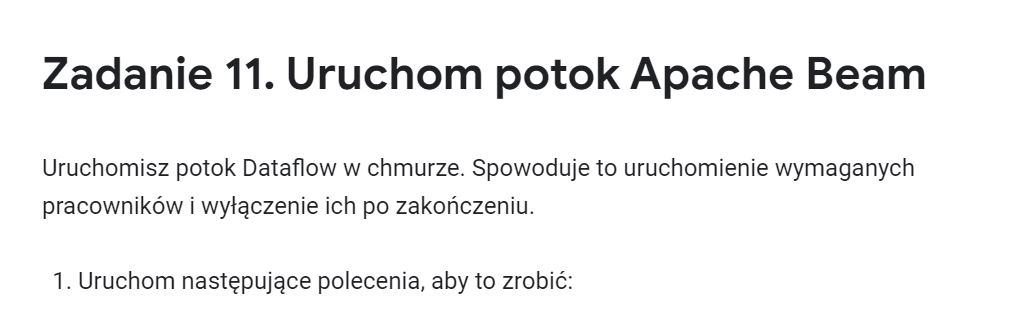

In [ ]:
python dataflow_python_examples/data_transformation.py \
  --project=$PROJECT \
  --region= \
  --runner=DataflowRunner \
  --staging_location=gs://$PROJECT/test \
  --temp_location gs://$PROJECT/test \
  --input gs://$PROJECT/data_files/head_usa_names.csv \
  --save_main_session

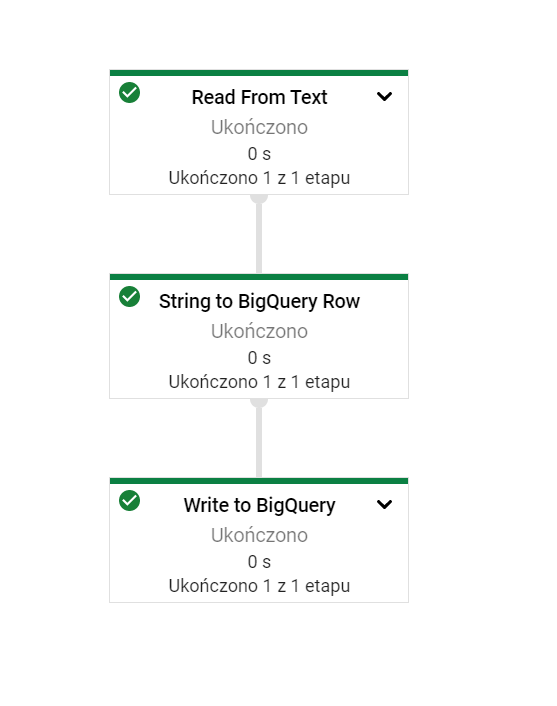

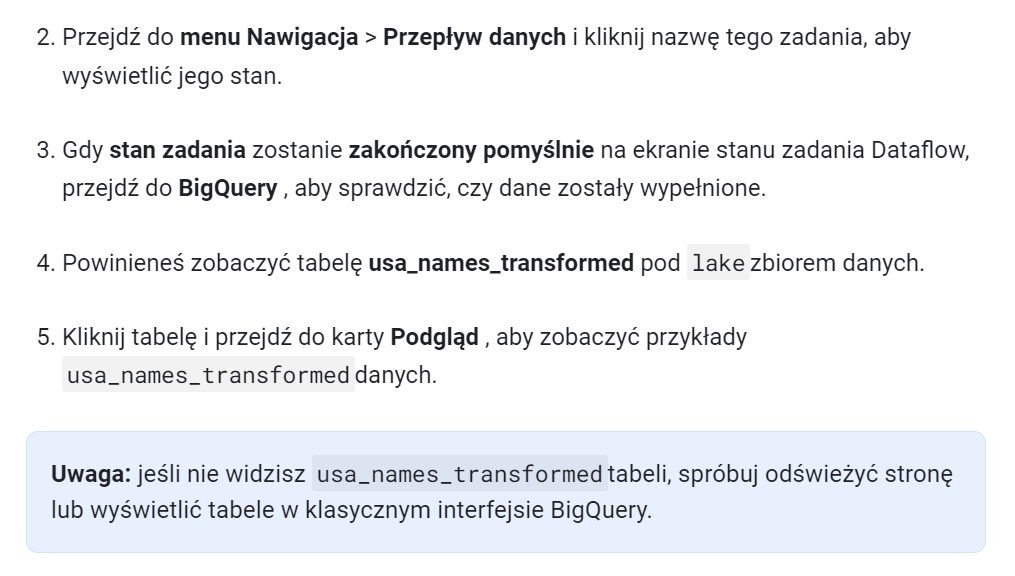

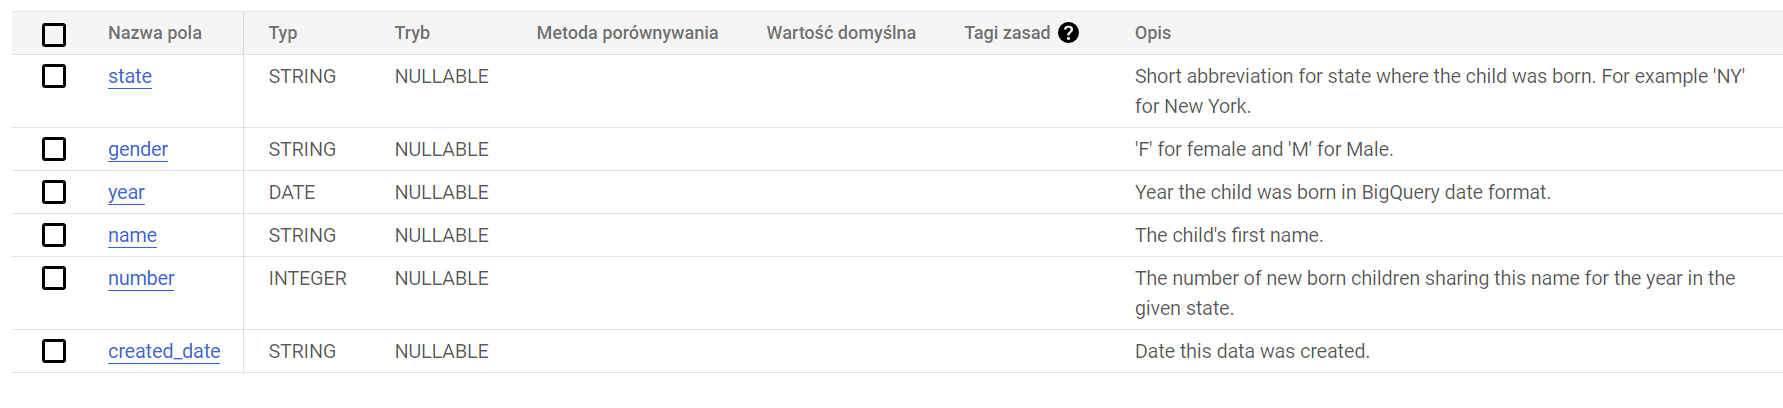

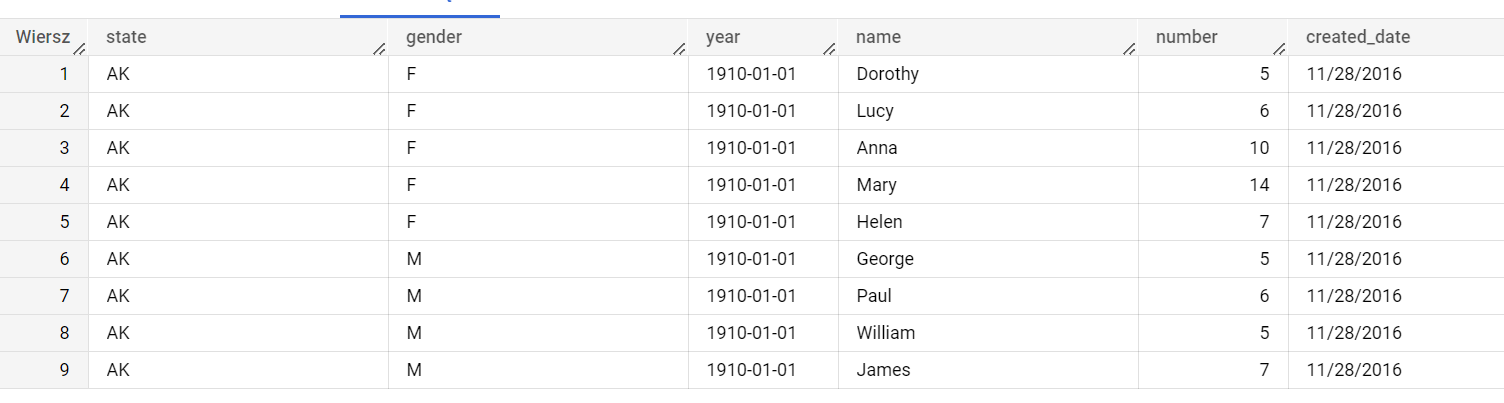

#Zadanie 12. Wzbogacanie danych

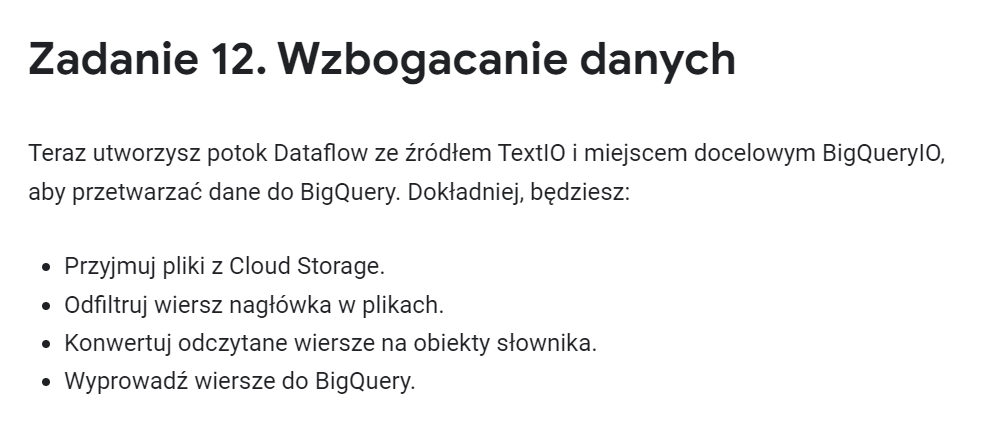

##`data_enrichment.py`

In [ ]:
# Copyright 2017 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

""" data_enrichment.py demonstrates a Dataflow pipeline which reads a file and
 writes its contents to a BigQuery table.  Along the way, data from BigQuery
 is read in as a side input and joined in with the primary data from the file.

"""


import argparse
import csv
import logging
import os
import sys

import apache_beam as beam
from apache_beam.io.gcp import bigquery
from apache_beam.io.gcp.bigquery import parse_table_schema_from_json
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.pvalue import AsDict


class DataIngestion(object):
    """A helper class which contains the logic to translate the file into a
  format BigQuery will accept."""

    def __init__(self):
        dir_path = os.path.dirname(os.path.realpath(__file__))
        self.schema_str = ''
        # This is the schema of the destination table in BigQuery.
        schema_file = os.path.join(dir_path, 'resources', 'usa_names_with_full_state_name.json')
        with open(schema_file) \
                as f:
            data = f.read()
            # Wrapping the schema in fields is required for the BigQuery API.
            self.schema_str = '{"fields": ' + data + '}'

    def parse_method(self, string_input):
        """This method translates a single line of comma separated values to a
    dictionary which can be loaded into BigQuery.

        Args:
            string_input: A comma separated list of values in the form of
            state_abbreviation,gender,year,name,count_of_babies,dataset_created_date
                example string_input: KS,F,1923,Dorothy,654,11/28/2016

        Returns:
            A dict mapping BigQuery column names as keys to the corresponding value
            parsed from string_input.  In this example, the data is not transformed, and
            remains in the same format as the CSV.  There are no date format transformations.

                example output:
                      {'state': 'KS',
                       'gender': 'F',
                       'year': '1923-01-01', <- This is the BigQuery date format.
                       'name': 'Dorothy',
                       'number': '654',
                       'created_date': '11/28/2016'
                       }

     """
        # Strip out return characters and quote characters.
        schema = bigquery.parse_table_schema_from_json(self.schema_str)

        field_map = [f for f in schema.fields]

        # Use a CSV Reader which can handle quoted strings etc.
        reader = csv.reader(string_input.split('\n'))
        for csv_row in reader:
            if (sys.version_info.major < 3.0):
                values = [x.decode('utf8') for x in csv_row]
            else:
                values = csv_row
            # Our source data only contains year, so default January 1st as the
            # month and day.
            month = '01'
            day = '01'
            # The year comes from our source data.
            year = values[2]
            row = {}
            i = 0
            # Iterate over the values from our csv file, applying any transformation logic.
            for value in values:
                # If the schema indicates this field is a date format, we must
                # transform the date from the source data into a format that
                # BigQuery can understand.
                if field_map[i].type == 'DATE':
                    # Format the date to YYYY-MM-DD format which BigQuery
                    # accepts.
                    value = '-'.join((year, month, day))

                row[field_map[i].name] = value
                i += 1

            return row


def run(argv=None):
    """The main function which creates the pipeline and runs it."""
    parser = argparse.ArgumentParser()
    # Here we add some specific command line arguments we expect.   Specifically
    # we have the input file to load and the output table to write to.
    parser.add_argument(
        '--input', dest='input', required=False,
        help='Input file to read.  This can be a local file or '
             'a file in a Google Storage Bucket.',
        # This example file contains a total of only 10 lines.
        # Useful for quickly debugging on a small set of data
        default='gs://spls/gsp290/data_files/head_usa_names.csv')
    # The output defaults to the lake dataset in your BigQuery project.  You'll have
    # to create the lake dataset yourself using this command:
    # bq mk lake
    parser.add_argument('--output', dest='output', required=False,
                        help='Output BQ table to write results to.',
                        default='lake.usa_names_enriched')

    # Parse arguments from the command line.
    known_args, pipeline_args = parser.parse_known_args(argv)

    # DataIngestion is a class we built in this script to hold the logic for
    # transforming the file into a BigQuery table.
    data_ingestion = DataIngestion()

    # Initiate the pipeline using the pipeline arguments passed in from the
    # command line.  This includes information like where Dataflow should store
    #  temp files, and what the project id is
    p = beam.Pipeline(options=PipelineOptions(pipeline_args))
    schema = parse_table_schema_from_json(data_ingestion.schema_str)

    # This function adds in a full state name by looking up the
    # full name in the short_to_long_name_map.  The short_to_long_name_map
    # comes from a read from BigQuery in the next few lines
    def add_full_state_name(row, short_to_long_name_map):
        row['state_full_name'] = short_to_long_name_map[row['state']]
        return row

    # This is a second source of data.  The source is from BigQuery.
    # This will come into our pipeline a side input.

    read_query = """
    SELECT
    name as state_name,
    abbreviation as state_abbreviation
    FROM
    `qwiklabs-resources.python_dataflow_example.state_abbreviations`"""

    state_abbreviations = (
        p
        | 'Read from BigQuery' >> beam.io.Read(
            beam.io.BigQuerySource(query=read_query, use_standard_sql=True))
        # We must create a python tuple of key to value pairs here in order to
        # use the data as a side input.  Dataflow will use the keys to distribute the
        # work to the correct worker.
        | 'Abbreviation to Full Name' >> beam.Map(
            lambda row: (row['state_abbreviation'], row['state_name'])))

    (p
     # Read the file.  This is the source of the pipeline.  All further
     # processing starts with lines read from the file.  We use the input
     # argument from the command line.  We also skip the first line which is
     # a header row.
     | 'Read From Text' >> beam.io.ReadFromText(known_args.input,
                                                skip_header_lines=1)
     # Translates from the raw string data in the CSV to a dictionary.
     # The dictionary is a keyed by column names with the values being the values
     # we want to store in BigQuery.
     | 'String to BigQuery Row' >> beam.Map(lambda s:
                                            data_ingestion.parse_method(s))
     # Here we pass in a side input, which is data that comes from outside our
     # CSV source.  The side input contains a map of states to their full name.
     | 'Join Data' >> beam.Map(add_full_state_name, AsDict(
        state_abbreviations))
     # This is the final stage of the pipeline, where we define the destination
     #  of the data.  In this case we are writing to BigQuery.
     | 'Write to BigQuery' >> beam.io.Write(
        beam.io.BigQuerySink(
            # The table name is a required argument for the BigQuery sink.
            # In this case we use the value passed in from the command line.
            known_args.output,
            # Here we use the JSON schema read in from a JSON file.
            # Specifying the schema allows the API to create the table correctly if it does not yet exist.
            schema=schema,
            # Creates the table in BigQuery if it does not yet exist.
            create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
            # Deletes all data in the BigQuery table before writing.
            write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE)))
    p.run().wait_until_finish()


if __name__ == '__main__':
    logging.getLogger().setLevel(logging.INFO)
    run()

#Zadanie 13. Przejrzyj kod potoku wzbogacania danych

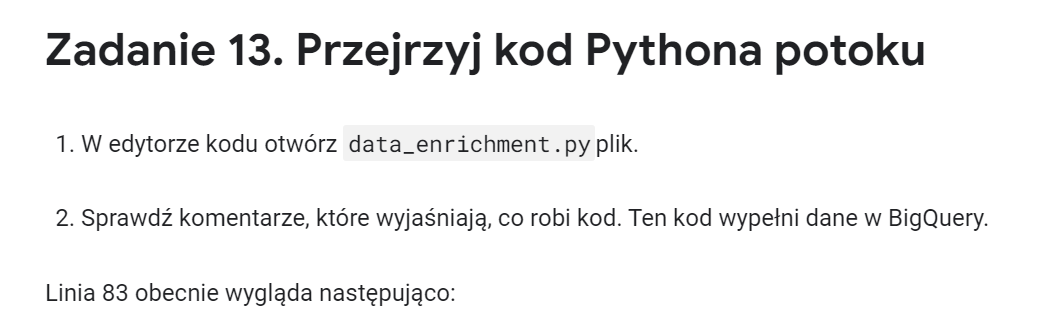

In [ ]:
values = [x.decode('utf8') for x in csv_row]

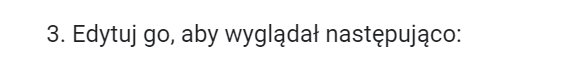

In [ ]:
values = [x for x in csv_row]

#Zadanie 14. Uruchom potok Data Enrichment Dataflow

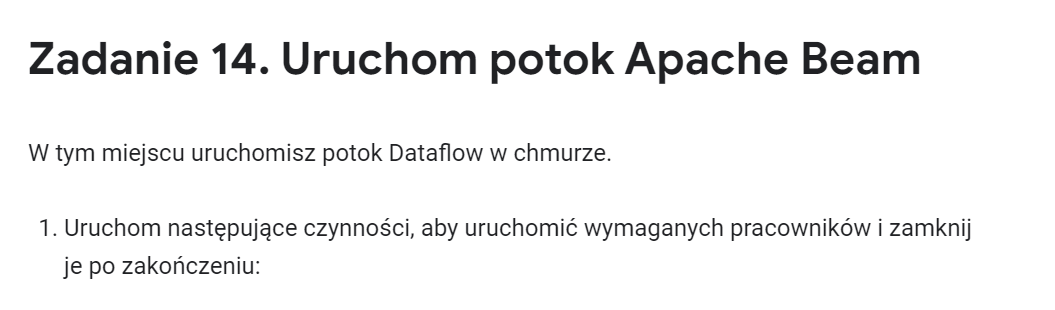

In [ ]:
python dataflow_python_examples/data_enrichment.py \
  --project=$PROJECT \
  --region= \
  --runner=DataflowRunner \
  --staging_location=gs://$PROJECT/test \
  --temp_location gs://$PROJECT/test \
  --input gs://$PROJECT/data_files/head_usa_names.csv \
  --save_main_session

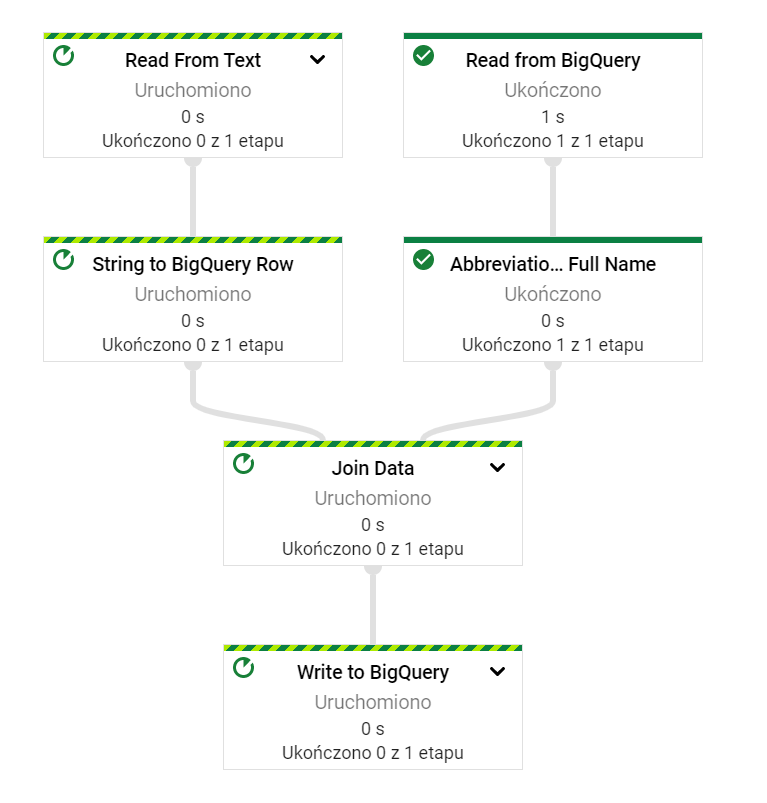

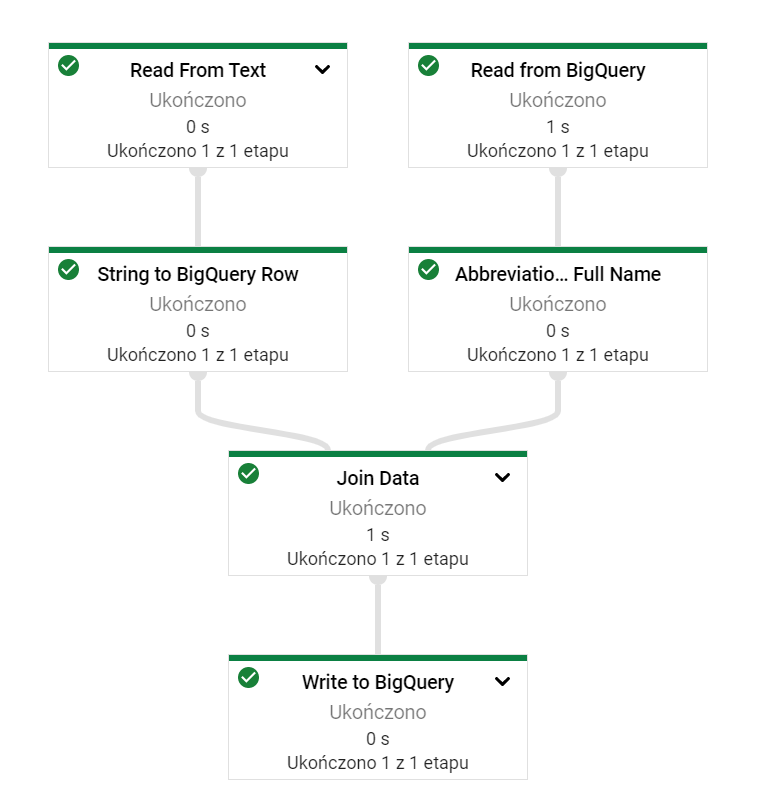

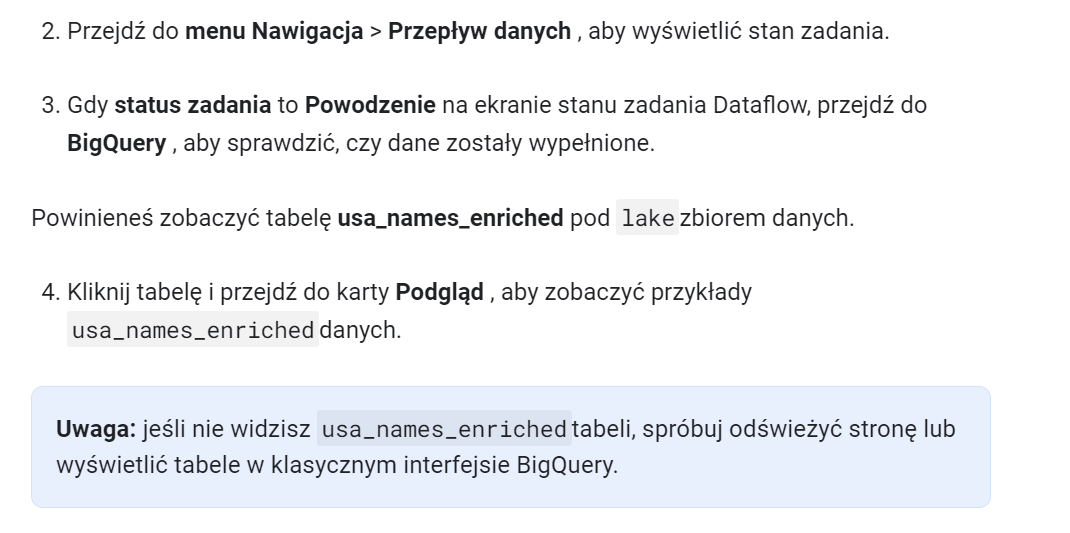

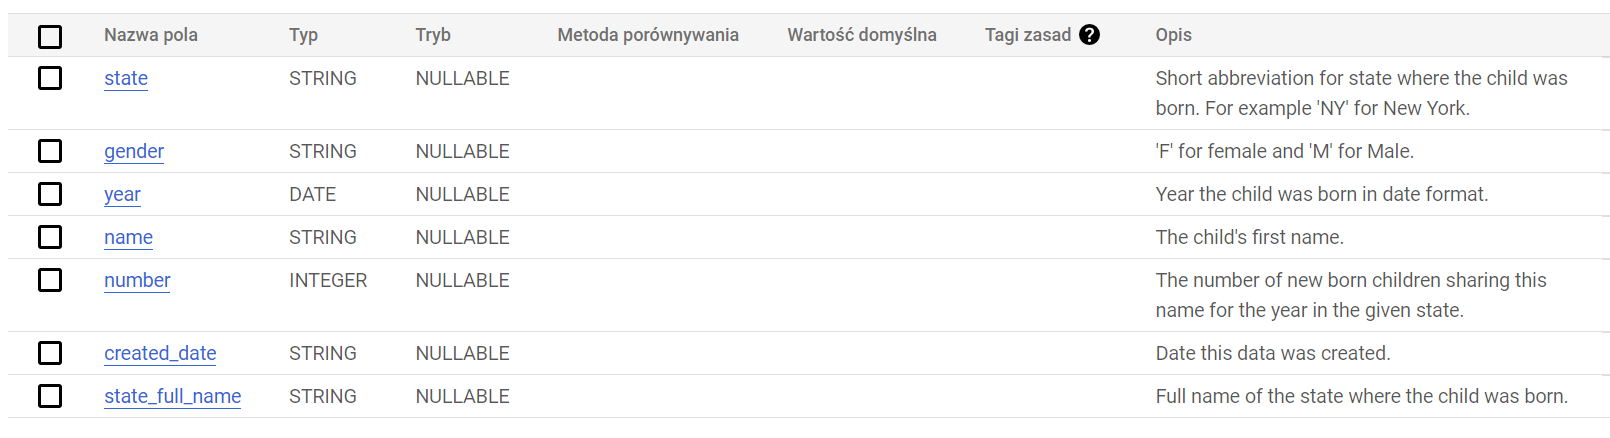

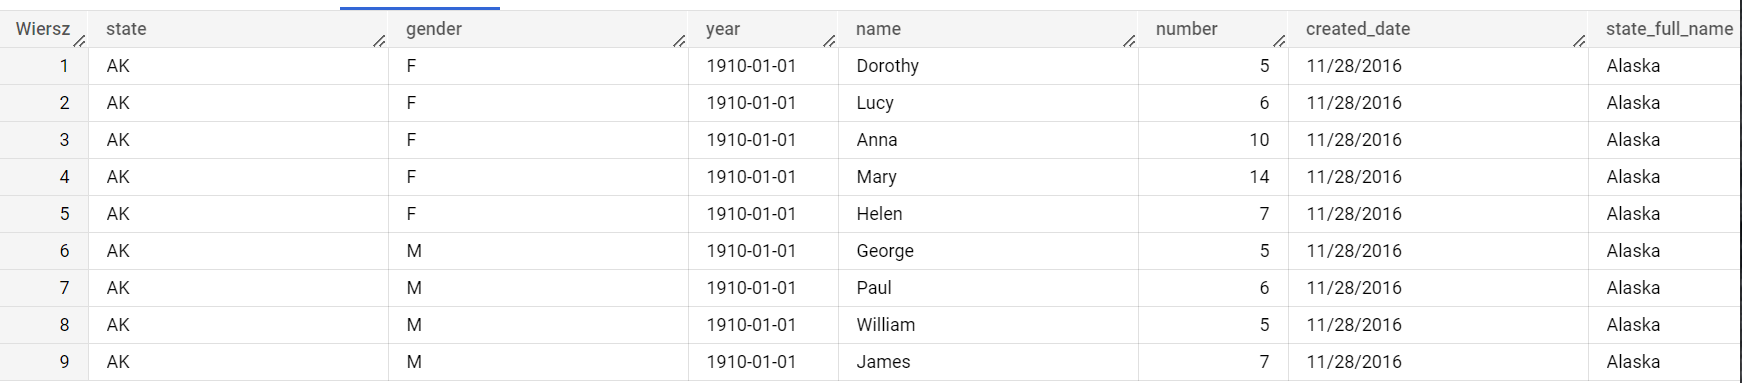

#Zadanie 15. Jezioro danych do Mart i przegląd kodu Pythona potoku

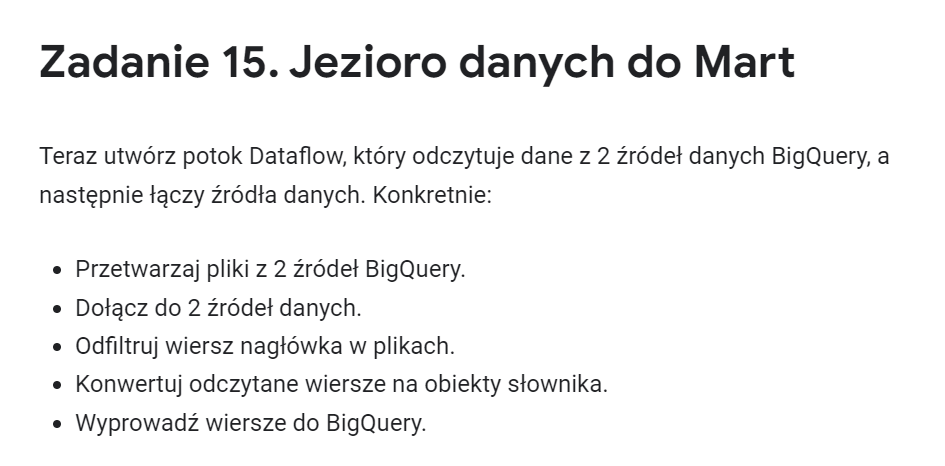

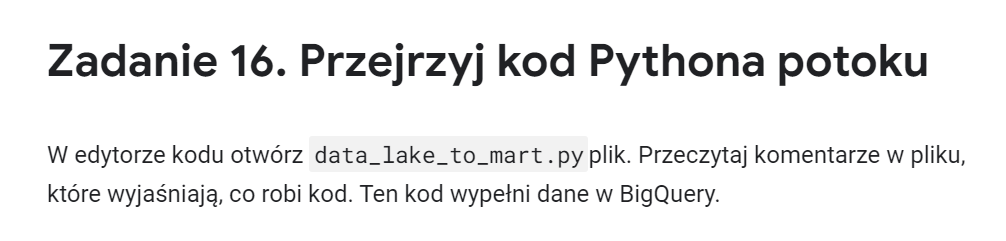

##`data_lake_to_mart.py`

In [ ]:
# Copyright 2017 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

""" data_lake_to_mart.py demonstrates a Dataflow pipeline which reads a
large BigQuery Table, joins in another dataset, and writes its contents to a
BigQuery table.
"""


import argparse
import logging
import os
import traceback

import apache_beam as beam
from apache_beam.io.gcp.bigquery import parse_table_schema_from_json
from apache_beam.options.pipeline_options import PipelineOptions
from apache_beam.pvalue import AsDict


class DataLakeToDataMart:
    """A helper class which contains the logic to translate the file into
    a format BigQuery will accept.

    This example uses side inputs to join two datasets together.
    """

    def __init__(self):
        dir_path = os.path.dirname(os.path.realpath(__file__))
        self.schema_str = ''
        # This is the schema of the destination table in BigQuery.
        schema_file = os.path.join(dir_path, 'resources', 'orders_denormalized.json')
        with open(schema_file) as f:
            data = f.read()
            # Wrapping the schema in fields is required for the BigQuery API.
            self.schema_str = '{"fields": ' + data + '}'

    def get_orders_query(self):
        """This returns a query against a very large fact table.  We are
        using a fake orders dataset to simulate a fact table in a typical
        data warehouse."""
        orders_query = """SELECT
            acct_number,
            col_number,
            col_number_1,
            col_number_10,
            col_number_100,
            col_number_101,
            col_number_102,
            col_number_103,
            col_number_104,
            col_number_105,
            col_number_106,
            col_number_107,
            col_number_108,
            col_number_109,
            col_number_11,
            col_number_110,
            col_number_111,
            col_number_112,
            col_number_113,
            col_number_114,
            col_number_115,
            col_number_116,
            col_number_117,
            col_number_118,
            col_number_119,
            col_number_12,
            col_number_120,
            col_number_121,
            col_number_122,
            col_number_123,
            col_number_124,
            col_number_125,
            col_number_126,
            col_number_127,
            col_number_128,
            col_number_129,
            col_number_13,
            col_number_130,
            col_number_131,
            col_number_132,
            col_number_133,
            col_number_134,
            col_number_135,
            col_number_136,
            col_number_14,
            col_number_15,
            col_number_16,
            col_number_17,
            col_number_18,
            col_number_19,
            col_number_2,
            col_number_20,
            col_number_21,
            col_number_22,
            col_number_23,
            col_number_24,
            col_number_25,
            col_number_26,
            col_number_27,
            col_number_28,
            col_number_29,
            col_number_3,
            col_number_30,
            col_number_31,
            col_number_32,
            col_number_33,
            col_number_34,
            col_number_35,
            col_number_36,
            col_number_37,
            col_number_38,
            col_number_39,
            col_number_4,
            col_number_40,
            col_number_41,
            col_number_42,
            col_number_43,
            col_number_44,
            col_number_45,
            col_number_46,
            col_number_47,
            col_number_48,
            col_number_49,
            col_number_5,
            col_number_50,
            col_number_51,
            col_number_52,
            col_number_53,
            col_number_54,
            col_number_55,
            col_number_56,
            col_number_57,
            col_number_58,
            col_number_59,
            col_number_6,
            col_number_60,
            col_number_61,
            col_number_62,
            col_number_63,
            col_number_64,
            col_number_65,
            col_number_66,
            col_number_67,
            col_number_68,
            col_number_69,
            col_number_7,
            col_number_70,
            col_number_71,
            col_number_72,
            col_number_73,
            col_number_74,
            col_number_75,
            col_number_76,
            col_number_77,
            col_number_78,
            col_number_79,
            col_number_8,
            col_number_80,
            col_number_81,
            col_number_82,
            col_number_83,
            col_number_84,
            col_number_85,
            col_number_86,
            col_number_87,
            col_number_88,
            col_number_89,
            col_number_9,
            col_number_90,
            col_number_91,
            col_number_92,
            col_number_93,
            col_number_94,
            col_number_95,
            col_number_96,
            col_number_97,
            col_number_98,
            col_number_99,
            col_number_num1,
            date,
            foo,
            num1,
            num2,
            num3,
            num5,
            num6,
            product_number,
            quantity
        FROM
            `qwiklabs-resources.python_dataflow_example.orders` orders
        LIMIT
            10
        """
        return orders_query

    def add_account_details(self, row, account_details):
        """add_account_details joins two datasets together.  Dataflow passes in the
        a row from the orders dataset along with the entire account details dataset.

        This works because the entire account details dataset can be passed in memory.

        The function then looks up the account details, and adds all columns to a result
        dictionary, which will be written to BigQuery."""
        result = row.copy()
        try:
            result.update(account_details[row['acct_number']])
        except KeyError as err:
            traceback.print_exc()
            logging.error("Account Not Found error: %s", err)
        return result


def run(argv=None):
    """The main function which creates the pipeline and runs it."""
    parser = argparse.ArgumentParser()
    # Here we add some specific command line arguments we expect.   S
    # This defaults the output table in your BigQuery you'll have
    # to create the example_data dataset yourself using bq mk temp
    parser.add_argument('--output', dest='output', required=False,
                        help='Output BQ table to write results to.',
                        default='lake.orders_denormalized_sideinput')

    # Parse arguments from the command line.
    known_args, pipeline_args = parser.parse_known_args(argv)

    # DataLakeToDataMart is a class we built in this script to hold the logic for
    # transforming the file into a BigQuery table.
    data_lake_to_data_mart = DataLakeToDataMart()

    p = beam.Pipeline(options=PipelineOptions(pipeline_args))
    schema = parse_table_schema_from_json(data_lake_to_data_mart.schema_str)
    pipeline = beam.Pipeline(options=PipelineOptions(pipeline_args))

    # This query returns details about the account, normalized into a
    # different table.  We will be joining the data in to the main orders dataset in order
    # to create a denormalized table.
    account_details_source = (
        pipeline
        | 'Read Account Details from BigQuery ' >> beam.io.Read(
            beam.io.BigQuerySource(query="""
                SELECT
                  acct_number,
                  acct_company_name,
                  acct_group_name,
                  acct_name,
                  acct_org_name,
                  address,
                  city,
                  state,
                  zip_code,
                  country
                FROM
                  `qwiklabs-resources.python_dataflow_example.account`""",
                                   # This next stage of the pipeline maps the acct_number to a single row of
                                   # results from BigQuery.  Mapping this way helps Dataflow move your data around
                                   # to different workers.  When later stages of the pipeline run, all results from
                                   # a given account number will run on one worker.
                                   use_standard_sql=True))
        | 'Account Details' >> beam.Map(
            lambda row: (
                row['acct_number'], row
            )))

    orders_query = data_lake_to_data_mart.get_orders_query()
    (p
     # Read the orders from BigQuery.  This is the source of the pipeline.  All further
     # processing starts with rows read from the query results here.
     | 'Read Orders from BigQuery ' >> beam.io.Read(
        beam.io.BigQuerySource(query=orders_query, use_standard_sql=True))
     # Here we pass in a side input, which is data that comes from outside our
     # main source.  The side input contains a map of states to their full name
     | 'Join Data with sideInput' >> beam.Map(data_lake_to_data_mart.add_account_details, AsDict(
        account_details_source))
     # This is the final stage of the pipeline, where we define the destination
     # of the data.  In this case we are writing to BigQuery.
     | 'Write Data to BigQuery' >> beam.io.Write(
        beam.io.BigQuerySink(
            # The table name is a required argument for the BigQuery sink.
            # In this case we use the value passed in from the command line.
            known_args.output,
            # Here we use the JSON schema read in from a JSON file.
            # Specifying the schema allows the API to create the table correctly if it does not yet exist.
            schema=schema,
            # Creates the table in BigQuery if it does not yet exist.
            create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
            # Deletes all data in the BigQuery table before writing.
            write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE)))
    p.run().wait_until_finish()


if __name__ == '__main__':
    logging.getLogger().setLevel(logging.INFO)
    run()

#Zadanie 16. Uruchom Apache Beam Pipeline, aby wykonać łączenie danych i utworzyć wynikową tabelę w BigQuery

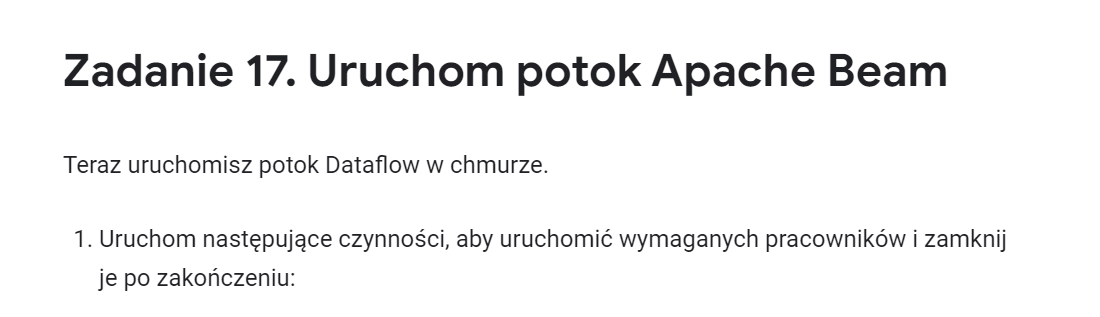

In [ ]:
python dataflow_python_examples/data_lake_to_mart.py \
  --worker_disk_type="compute.googleapis.com/projects//zones//diskTypes/pd-ssd" \
  --max_num_workers=4 \
  --project=$PROJECT \
  --runner=DataflowRunner \
  --staging_location=gs://$PROJECT/test \
  --temp_location gs://$PROJECT/test \
  --save_main_session \
  --region=

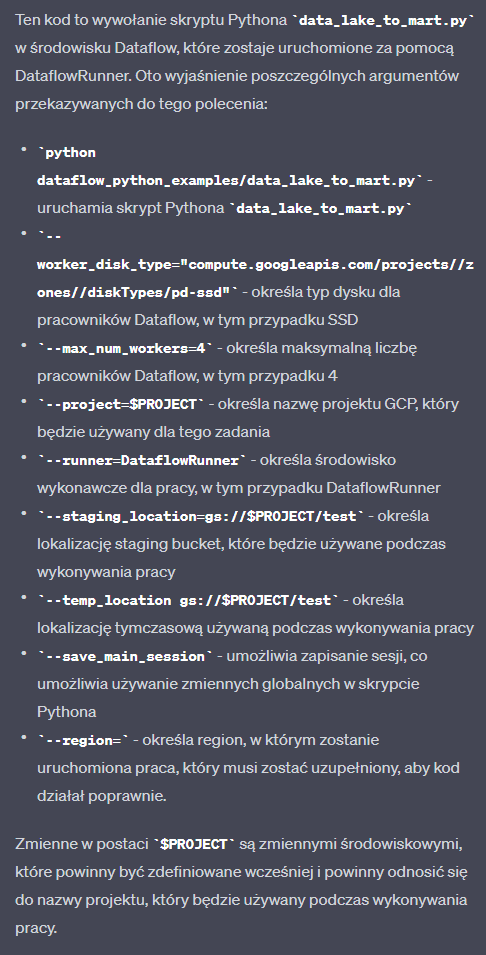

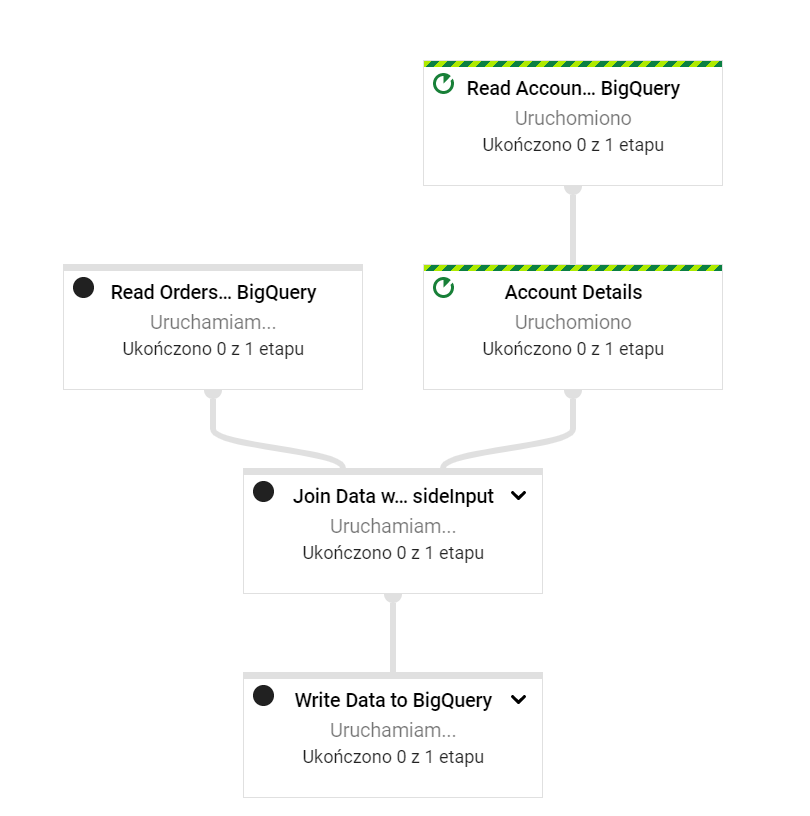

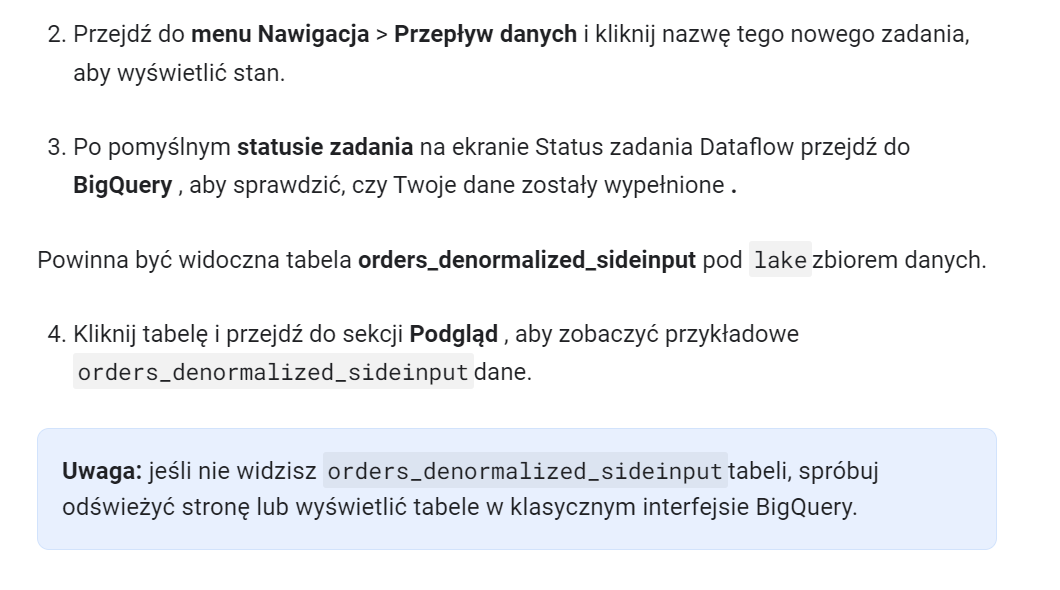

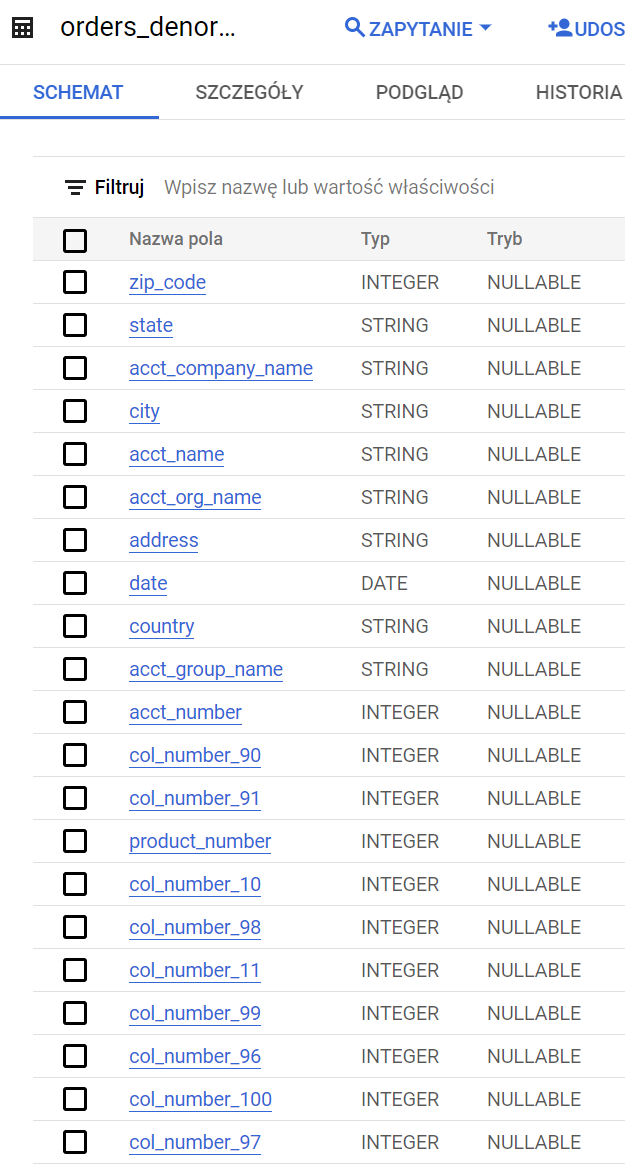

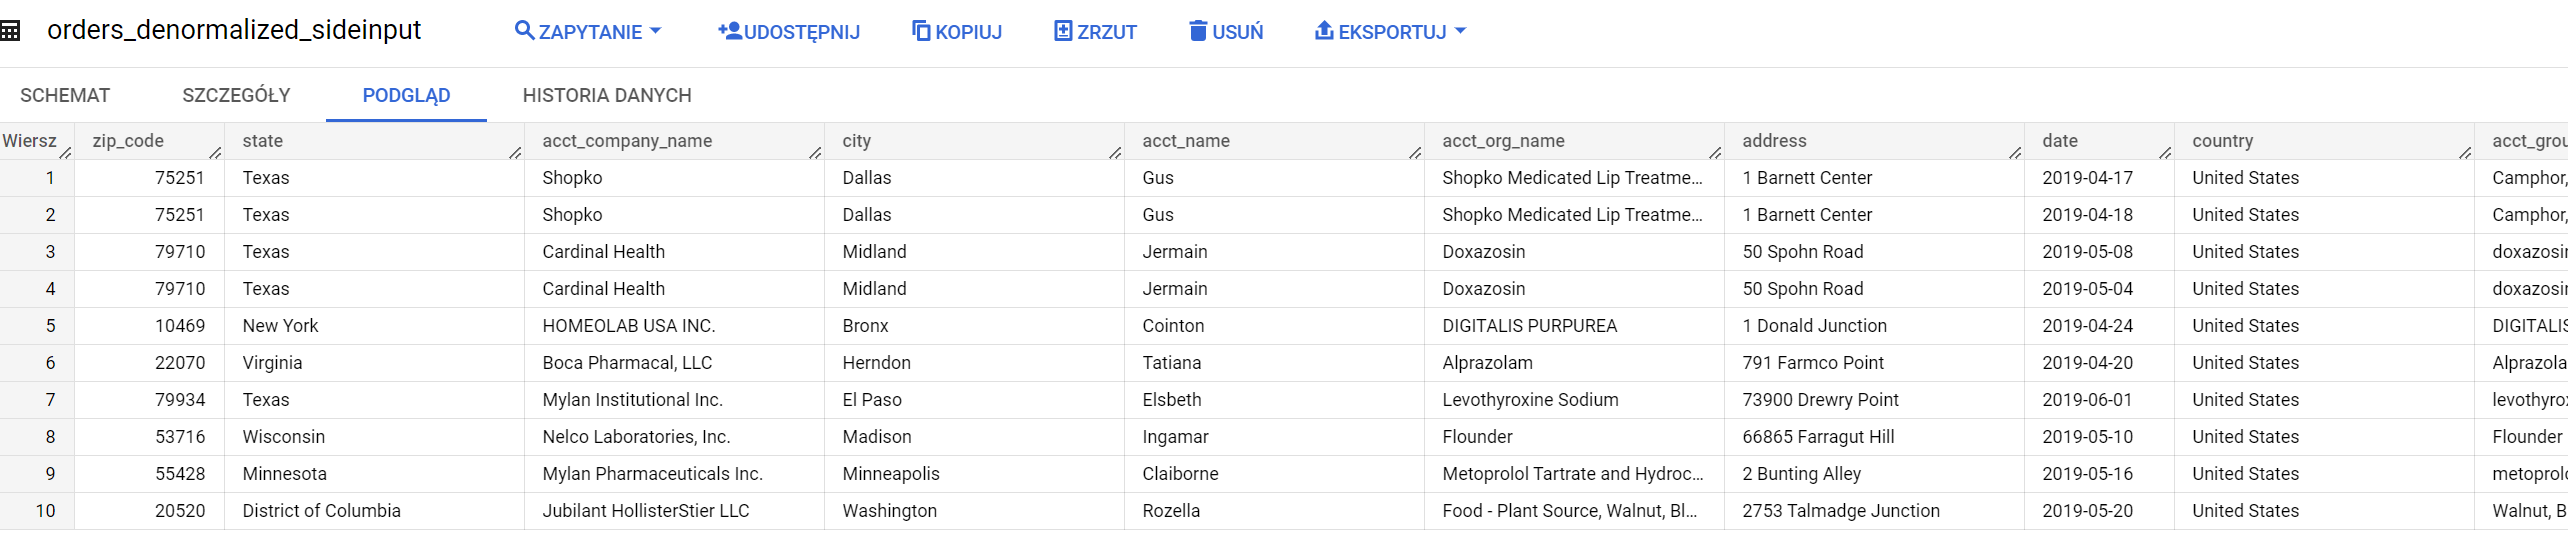

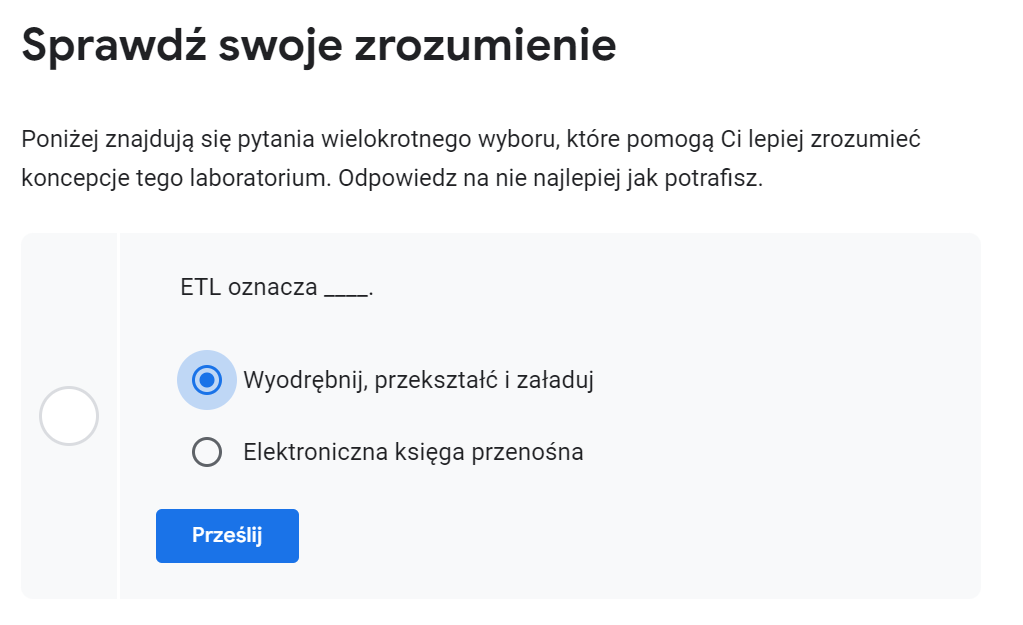

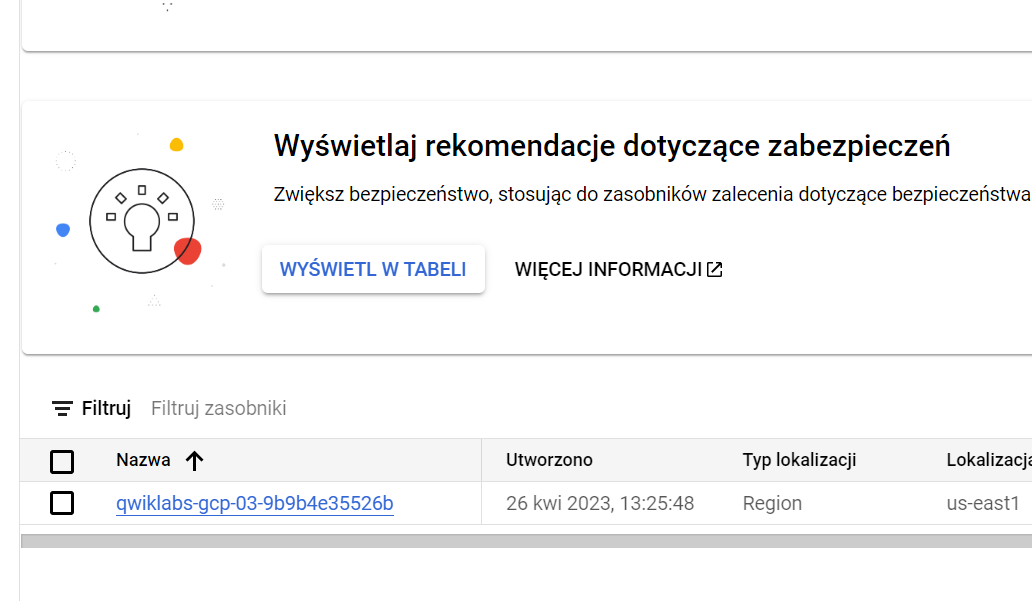

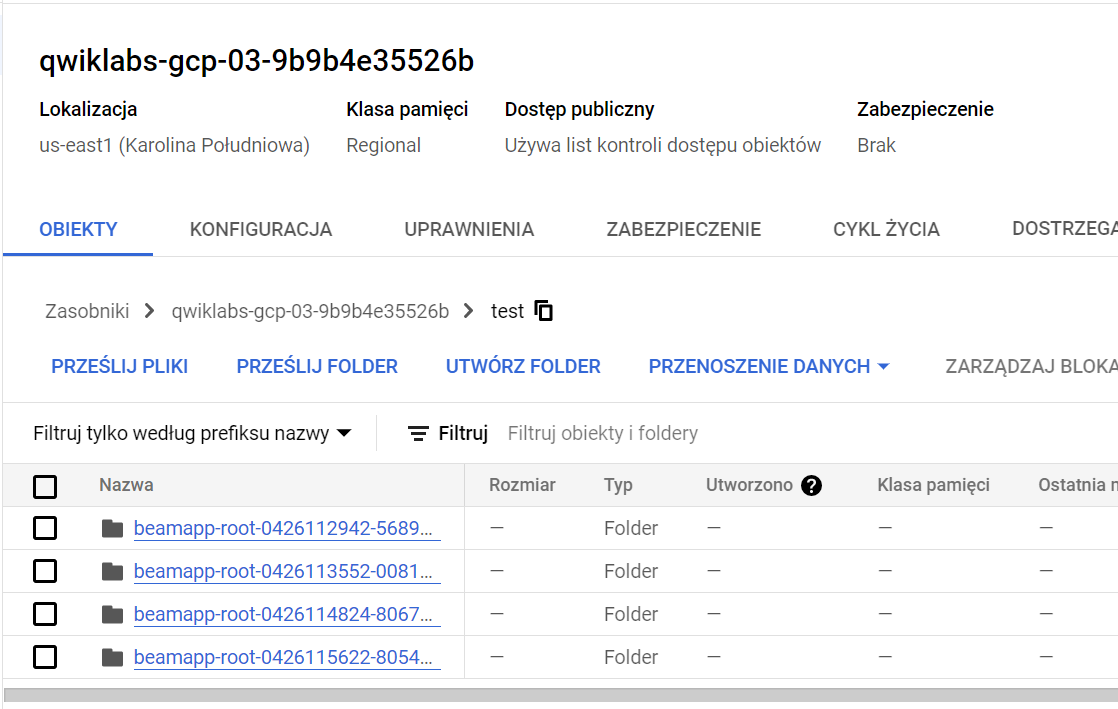